# Introduction

This notebook implements Differential Evolution with Novel Parameter Control (DE-NPC) proposed by Meng et al. (2020) [1]. 

Using DE-NPC and MNIST [2], an adversarial image is generated. The prediction of an RBF Network on the adversarial image and original image is displayed.

[1] Meng, Z., Chen, Y., & Li, X. (2020). Enhancing differential evolution with novel parametercontrol. IEEE Access,8, 51145–51167. \\
[2] LeCun, Y., Cortes, C., & Burges, C.  (2010). MNIST handwritten digit database.



# Libraries

In [1]:
!pip install PyDrive
!pip install keras==2.2.4
!pip install tensorflow==1.13.1
!pip install git+https://github.com/darecophoenixx/wordroid.sblo.jp

  Cloning https://github.com/darecophoenixx/wordroid.sblo.jp to /tmp/pip-req-build-hrrkzzf5
  Running command git clone -q https://github.com/darecophoenixx/wordroid.sblo.jp /tmp/pip-req-build-hrrkzzf5
  Created wheel for wordroid.sblo.jp: filename=wordroid.sblo.jp-0.0.1-cp36-none-any.whl size=33710 sha256=ce0c3750f0cf3f64219670a955c830b6895a3389a1556c493fc3eb34ea02ed22
  Stored in directory: /tmp/pip-ephem-wheel-cache-nlcl37p6/wheels/3d/6d/24/44e7d6dc47b39e74772a04beb27433ba2ebed90876394cda60
Successfully built wordroid.sblo.jp


In [2]:
%matplotlib inline
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import to_categorical
import tensorflow as tf
from keras_ex.gkernel import GaussianKernel, GaussianKernel2, GaussianKernel3
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from scipy.stats import cauchy 
from scipy import stats
import time
import operator
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans

#Set seeds
random.seed(0)
np.random.seed(0)

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

# DE_NPC Class

In [0]:
#https://www.geeksforgeeks.org/python-peak-signal-to-noise-ratio-psnr/
from math import log10, sqrt 
import cv2 
def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr 

In [0]:
# https://stackoverflow.com/questions/1401712/how-can-the-euclidean-distance-be-calculated-with-numpy
def euclidean(s):
    # pass s=a-b as argument to the function
    return np.linalg.norm(s)

In [0]:
class DE_NPC:
  def __init__(self,param_dict):
    ###Load Params##
    self.img = param_dict["input"]
    self.imsize = param_dict["input_size"]
    self.imclass = param_dict["imclass"]
    self.mean = param_dict["mean"]
    self.std = param_dict["std"]
    self.R_min = param_dict["R_min"]
    self.R_max = param_dict["R_max"]
    self.nfe_max = param_dict["nfe_max"]
    self.PS_ini = param_dict["PS_ini"]
    self.PS_min = param_dict["PS_min"]
    self.K = param_dict["K"]
    self.rarc = param_dict["rarc"]
    self.p = param_dict["p"]
    self.model = param_dict["model"]

    ####Initialize Params####
    self.set_params()

  #Fitness function
  def fitness_func(self,individual):
    individual = individual.reshape(1,self.imsize)
    pred = self.model.predict(individual  / 255.0)
    pred = pred[0]
    po = pred[self.imclass]
    pred[self.imclass] = 0
    pd = np.max(pred)
    diff = pd-po
    return (0.5)*diff + (-0.5)*euclidean(individual-self.img.reshape(1,self.imsize))/(self.imsize*255) 

  #Given the population and img(whihc is necessary to calculate the fitness function)
  #choose one individual whose fitness value is in top p percent.
  def get_top_p(self,PS,p):
    num_best = int(PS*p)
    fitness =  [(individual,self.fitness_func(individual)) for individual in self.population[0:PS]]
    fitness.sort(key=lambda x: x[1])
    fitness = fitness[-num_best:]
    return random.choice(fitness)[0]

  def execute(self, model):
    not_improving = 0
    nfe = 0
    PS = self.PS_ini
    A_ind = 0
    G = 1
    start = time.time()
    while nfe < self.nfe_max:
      #############################INITIALIZATION###################################
      #Sets of successfull f and cr values
      #with the corresponding weights
      s_f = [[] for i in range(self.K)]
      s_f_weights = [[] for i in range(self.K)]
      s_cr = [[] for i in range(self.K)]
      s_cr_weights = [[] for i in range(self.K)]
      #the selected k values for this iteration
      k_selections = np.zeros((self.K,PS))
      #how many times the specific k value was a success/failure
      k_success = np.zeros((self.K,1))
      k_failure = np.zeros((self.K,1))

      ####################ADJUST POPULATION AND A###################################
      #Adjustment done due to keep the individuals' values in range.
      #and to reduce the array sizes. However, even if the population size gets 
      #smaller than PS, since the loops are in range(PS), the individuals stored in 
      #the population vector in indices > PS will not be reached. 
      #Instead of picking discarded individuals randomly, we shuffle the population
      #and archive array. It should amount to picking random.
      if G > 2:
        #Adjust the individuals of the population; 
        for i in range(PS):
          self.population[i] = np.clip(self.population[i], self.R_min, self.R_max).reshape(self.imsize)
        #Adjust storage A; 
        for i in range(self.A_size):
          self.A[i] = np.clip(self.A[i], self.R_min, self.R_max).reshape(self.imsize)
        np.random.shuffle(self.A)
        np.random.shuffle(self.population)

      #############################SELECT K,F,CR'S##################################  
      #We select a k value for each individual in the population
      #with respect to the selection probabilities (p_k) of each k.
      custm = stats.rv_discrete(name='custm', values=(np.arange(self.K).reshape(self.K,1), self.p_k))
      k_selections = custm.rvs(size=PS)
      #Get f and cr values for each individual
      for i in range(PS):
        self.cr[i]  = np.random.normal(self.mu_cr[k_selections[i]], 0.1, 1)
        if self.cr[i] < 0:
          self.cr[i] = 0
        self.f[i] = cauchy.rvs(self.mu_f[k_selections[i]],0.1,1)
        while self.f[i] <= 0:
          self.f[i] = cauchy.rvs(self.mu_f[k_selections[i]],0.1,1)
        if self.f[i] > 1:
          self.f[i] = 1
      
      ####################GENERATE U,V AND CALCULATE FITNESS########################
      #Generate donor and trial (U and V) vectors
      #Calculate the fitness values
      for i in range(PS):
        X_p_best =  self.get_top_p(PS,self.p).reshape((self.imsize,1))
        #X_r_1 denotes a random vector selection from the current population
        X_r_1 = random.choice(self.population[:PS]).reshape((self.imsize,1))
        #X_hat_r_2 denotes a randomly selected solution from the union A and P
        X_hat_r_2 = random.choice(np.concatenate((self.population[:PS], self.A[:self.A_size]), axis=0)).reshape((self.imsize,1))
        #mutation, generate trial vector
        self.V[i] = (self.population[i].reshape((self.imsize,1)) + self.f[i]*(X_p_best - self.population[i].reshape((self.imsize,1)))
               + self.f[i]*(X_r_1 - X_hat_r_2)).reshape(self.imsize)
        #crossover, generate donor vector
        self.U[i] = self.population[i]
        for j in range(self.imsize):
          if random.uniform(0, 1) <= self.cr[i]:
            self.U[i][j] = self.V[i][j]
        self.fitness_ind[i] = self.fitness_func(self.population[i])
        self.fitness_U[i] = self.fitness_func(self.U[i])

      ################################INCREMENT nfe#################################
      #Increment nfe
      nfe += PS

      #####################DETERMINE UN/SUCCESSFULL#################################
      #Determine the successful and unsuccessful cr,f,k values.
      #Add unsuccessful individuals to the archive
      for i in range(PS):
        k = k_selections[i]
        if self.fitness_ind[i] <= self.fitness_U[i]:
          s_cr[k].append(self.cr[i])
          s_cr_weights[k].append(np.std(np.subtract(self.population[i],self.U[i])))
          s_f[k].append(self.f[i])
          s_f_weights[k].append(self.fitness_U[i]-self.fitness_ind[i])
          self.population[i] = self.U[i]
          k_success[k] += 1
        else:
          if A_ind >= self.A_size:
            A_ind = 0
          self.A[A_ind] = self.population[i]
          A_ind += 1
          k_failure[k] += 1

      ######################UPDATE MU_CR AND MU_F's#################################
      #update params (mixed with Jade-like update)
      for k in range(self.K):
        if len(s_cr[k]) != 0:
          s_cr_weights[k] = s_cr_weights[k]/np.sum(s_cr_weights[k])
          s_f_weights[k] = s_f_weights[k]/np.sum(s_f_weights[k])
          mean_cr = np.sum(np.multiply(np.square(s_cr[k]),s_cr_weights[k]))/np.sum(np.multiply(s_cr[k],s_cr_weights[k]))
          mean_f = np.sum(np.multiply(np.square(s_f[k]),s_f_weights[k]))/np.sum(np.multiply(s_f[k],s_f_weights[k]))  
          #update mu_cr
          if (np.max(s_cr[k]) > 0) and (self.mu_cr[k] != 0):
            self.mu_cr[k] = mean_cr
          #update mu_f
          self.mu_f[k] = mean_f

      ###########################UPDATE GROUP PROBS#################################
      #Update group probabilities
      for k in range(self.K):
        if k_success[k] != 0:
          k_success[k] = np.square(k_success[k])/(np.sum(k_success[k])*(k_success[k]+k_failure[k]))
        else:
          self.p_k[k] = 0.000000001
      self.p_k = self.p_k/np.sum(self.p_k)

      ###########################END ITERATION######################################
      #increment generation count
      G += 1
      #Get the best individual
      self.X_best = self.get_top_p(PS,1/PS)
      if G > 2: 
        dist = euclidean(self.X_best.reshape(self.imsize)-self.img.reshape(self.imsize))
        individual = self.X_best.reshape(1,self.imsize)
        pred = self.model.predict(np.clip(individual, 0, 255)  / 255.0)
        pred = pred[0]
        pred = np.argmax(pred)
        if dist<0.001 and pred != self.imclass[0]:
          self.X_best_fitness = self.fitness_func(self.X_best)
          print("FOUND! " ,nfe, " : "  ,self.X_best_fitness,PS)
          break
        if np.abs(self.X_best_fitness-self.fitness_func(self.X_best)) < 0.01:
          not_improving += 1
          if not_improving > 30:
             self.X_best_fitness = self.fitness_func(self.X_best)
             print(nfe, " : "  ,self.X_best_fitness,PS)
             break
        else:
          not_improving = 0

      #Get the fitness of best individual
      self.X_best_fitness = self.fitness_func(self.X_best)
      #Give feedback
      print(nfe, " : "  ,self.X_best_fitness,PS)

      ######################ADJUST POPULATION SIZE##################################
      #adjust population size 
      #else part changed. there is something wrong with the formula on the paper.
      #since the ends of the two partial functions do not meet, when nfe > x the 
      #population increases. change is to fix this.
      if nfe <= self.x:
        PS = int(np.ceil((((self.y-self.PS_ini)/np.square(self.x-self.PS_ini))*np.square(nfe-self.PS_ini)) + self.PS_ini))
      else:
        initial_formula = int(np.floor((((self.y-self.PS_ini)/(self.x-self.PS_min))*(nfe-self.nfe_max)) + self.PS_min))
        if initial_formula < PS:
          PS = initial_formula
      #adjust archive size according to the new population
      self.A_size = int(self.rarc*PS)
      #Note: archive update moved within "Determine un/successful" as the computation
      #would be too redundant.  
    end = time.time()
    print("Time: ",end-start ," seconds")
    return end-start,nfe

  def change_input(self,img,imclass,imsize):
    self.img = img
    self.imsize = imsize
    self.imclass = imclass
    self.set_params()

  def set_params(self):
    #Calculate pivot for dynamic population change
    self.x = (1/3)*self.nfe_max
    self.y = (2/3)*self.PS_ini     
    #probability of belonging to a group
    self.p_k = np.ones((self.K,1))*(1/self.K)   
    #archive
    self.A_size = int(self.PS_ini*self.rarc)
    self.A = np.zeros((self.A_size,self.imsize))
    #scale factor
    self.f = np.ones((self.PS_ini,1)) 
    self.mu_f = np.ones((self.K,1)) *0.5
    #crossover probability
    self.cr = np.ones((self.PS_ini,1)) 
    self.mu_cr = np.ones((self.K,1)) *0.5
    #Initial population
    self.population = np.zeros((self.PS_ini,self.imsize))
    #Fitness functions
    self.fitness_ind = np.zeros((self.PS_ini,1))
    self.fitness_U = np.zeros((self.PS_ini,1))
    #donor and trial vectors
    self.V = np.zeros((self.PS_ini,self.imsize))
    self.U = np.zeros((self.PS_ini,self.imsize))
    for i in range(self.PS_ini):
      noisy_img = self.img + np.random.normal(self.mean, self.std, (self.imsize,1))
      self.population[i] = np.clip(noisy_img, 0, 255).reshape(self.imsize)
    self.X_best = None
    self.X_best_fitness = None

# Download Neural Network

In [6]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded = drive.CreateFile({'id':"16oao6c9BTb33sbaFzCDJ1sGQn4Z0ILS7"}) 
downloaded.GetContentFile('rbfnn_v2.h5')   

num_lm0 = 100
num_lm = num_lm0 * 10
init_wgt = np.zeros(((1000, 784)))

inp = Input(shape=(28*28,), name='inp')
oup = GaussianKernel(num_lm, 28*28,
                     kernel_gamma='auto', weights=[init_wgt],
                     name='gkernel1')(inp)
oup = Dense(10, activation='softmax')(oup)
model = Model(inp, oup)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.load_weights("rbfnn_v2.h5")

Instructions for updating:
Colocations handled automatically by placer.


# Prepare Data

In [0]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

In [0]:
def prepare_data(X,y):
  X = X.reshape((X.shape[0], -1))
  X_sc = X / 255.0
  y_cat = to_categorical(y)
  return X_sc, y_cat

In [9]:
X_train = X_train.reshape((X_train.shape[0], -1))
X_sc = X_train / 255.0
X_sc.shape
y_cat = to_categorical(y_train)
X_test = X_test.reshape((X_test.shape[0], -1))
X_test_sc = X_test / 255.0
y_pred_test = model.predict(X_test_sc)
y_pred_train = model.predict(X_sc)
print("Training accuracy: ",accuracy_score(y_train,np.argmax(y_pred_train,axis=1)))
print("Test accuracy: ",accuracy_score(y_test,np.argmax(y_pred_test,axis=1)))

Training accuracy:  0.93305
Test accuracy:  0.9297


In [0]:
def sample_test_set(percentage,X_test,X_test_scaled,y_test,imsize,channels,num_clusters, num_classes,num_samples):
  original = []
  adversarial = []
  original_y = []
  adversarial_y = []
  for sample_class in range(num_classes):
    labels = y_test[(y_test==sample_class).reshape(num_samples)]
    samples_orig = X_test[(y_test==sample_class).reshape(num_samples)]
    samples = X_test_scaled[(y_test==sample_class).reshape(num_samples)]
    samples = samples.reshape((samples.shape[0],imsize*imsize*channels))
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit_predict(samples)
    for cluster in range(num_clusters):
      subsamples = np.where(kmeans==cluster)[0]
      ori, adv = train_test_split(subsamples,random_state=0, test_size = percentage ,shuffle=True)
      original.extend(samples_orig[ori])
      original_y.extend(labels[ori])
      adversarial.extend(samples_orig[adv])
      adversarial_y.extend(labels[adv])
  return np.array(original), np.array(adversarial), np.array(original_y), np.array(adversarial_y)

In [0]:
discard,subsample, discard_y, subsample_y = sample_test_set(0.1,X_test,X_test_sc,y_test,28,1,5,10,10000)

In [12]:
subsample.shape

(1021, 784)

In [13]:
subsample_y.shape

(1021,)

In [0]:
subsample_sc = subsample / 255.0
y_pred_subsample = model.predict(subsample_sc)

In [15]:
print("Accuracy on subsample: ", accuracy_score(subsample_y,np.argmax(y_pred_subsample,axis=1)))

Accuracy on subsample:  0.9333986287952988


In [0]:
original,adversarial, original_y, adversarial_y = sample_test_set(0.1,subsample,subsample_sc,subsample_y,28,1,5,10,1021)

In [17]:
original.shape

(895, 784)

In [18]:
adversarial.shape

(126, 784)

In [19]:
adversarial_y.shape

(126,)

In [0]:
import pickle
file_ = open('subset', 'wb')
pickle.dump(original, file_)
pickle.dump(adversarial, file_)
pickle.dump(original_y, file_)
pickle.dump(adversarial_y, file_)
file_.close()


# Evolve

In [0]:
param_dict = {
    "model" : model,
    #Image to be evolved
    "input" : adversarial[0].reshape((784,1)),
    "input_size" : 28*28,
    "imclass" : adversarial_y[0],
    #Mean and std for Gaussian noise
    #good results with 10-10
    "mean" : 0, #50(5)   #150 (1)
    "std" : 20, #50 (5) #200 (1)
    #Range
    "R_min" : 0.0,
    "R_max" : 255.0,
    #Maximum number of function evaluations
    "nfe_max" : 10000,#4000 #5000(6) #50000(3)  #10000 (2) (it was 2000)
    #Initial and minimum population size
    "PS_ini" : 25, #100 #200(4) (it was 125)
    "PS_min" : 4,
    #Number of groups
    "K" : 7,
    #ratio of the external archive size to the whole population PS
    "rarc" : 1.6,
    #percentage p when we select an individual among top p fits
    "p" : 0.11
}

25  :  0.32275857260377405 25
50  :  0.46339650821504735 25
75  :  0.45241614821810505 25
100  :  0.47216260351848877 25
125  :  0.4793007347577541 25
150  :  0.48185428774423494 25
175  :  0.48685025736785387 25
200  :  0.48835143259148694 25
225  :  0.48913714183884216 25
250  :  0.4896939457956086 25
275  :  0.48991428835459516 25
300  :  0.4902432189748568 25
325  :  0.49024236683991806 25
350  :  0.49059930007664976 25
375  :  0.4905949739428885 25
400  :  0.4907122666428317 25
425  :  0.49068064952164947 25
450  :  0.4907102114839553 25
475  :  0.49097449589802455 25
500  :  0.49099246127075774 25
525  :  0.49105966458513056 25
550  :  0.49111550333473347 25
575  :  0.49112156823808095 25
600  :  0.4911551661215699 25
625  :  0.4911473362767003 25
650  :  0.4912464508443688 25
675  :  0.4912464508443688 25
700  :  0.491297480111186 25
725  :  0.4913371641601373 25
750  :  0.491383618155698 25
775  :  0.49141571279467544 25
800  :  0.49154562110420746 25
825  :  0.4915485711621546

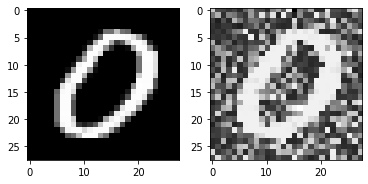

25  :  0.03228464890113445 25
50  :  0.4102322333363765 25
75  :  0.46126200246547816 25
100  :  0.4112244480930437 25
125  :  0.4807722453268344 25
150  :  0.48181830449883084 25
175  :  0.4869533336353999 25
200  :  0.48787587244824826 25
225  :  0.48864019278136644 25
250  :  0.48867062819043106 25
275  :  0.4901538098286011 25
300  :  0.49014101426995643 25
325  :  0.49041005554793243 25
350  :  0.49059544645173375 25
375  :  0.49102386827929917 25
400  :  0.49102386827929917 25
425  :  0.4910301841862044 25
450  :  0.4914706581560376 25
475  :  0.49166131137963337 25
500  :  0.4917294657061425 25
525  :  0.4917294657061425 25
550  :  0.49189614515798286 25
575  :  0.49189263351787066 25
600  :  0.49198527878896997 25
625  :  0.49204421043289265 25
650  :  0.4921131876975315 25
675  :  0.4921120947282746 25
700  :  0.49222888432242606 25
725  :  0.49223503199609125 25
750  :  0.4922574344778096 25
775  :  0.4923104279239665 25
800  :  0.4923241143863986 25
825  :  0.492377124116635

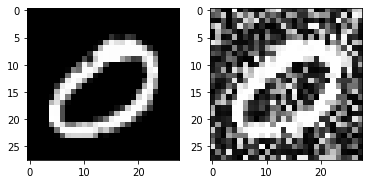

25  :  0.24332924298664585 25
50  :  0.4660388441639262 25
75  :  0.44575447811567637 25
100  :  0.4521861387442698 25
125  :  0.4712384027965484 25
150  :  0.48610045800235 25
175  :  0.4863105675068204 25
200  :  0.4890436420398214 25
225  :  0.4892331093352213 25
250  :  0.48956519882944677 25
275  :  0.4895936871401896 25
300  :  0.489858728553807 25
325  :  0.4898930901492839 25
350  :  0.49028417436414734 25
375  :  0.4903113883350464 25
400  :  0.4903975408258822 25
425  :  0.4903681466966128 25
450  :  0.4905185148127562 25
475  :  0.4908141983933361 25
500  :  0.49072420987998205 25
525  :  0.4908520990399347 25
550  :  0.49099240688435286 25
575  :  0.49116720643921147 25
600  :  0.4912202691942469 25
625  :  0.49119129927051014 25
650  :  0.49133134565860026 25
675  :  0.49134033992142334 25
700  :  0.49134033992142334 25
725  :  0.4913878734804375 25
750  :  0.4913851663971895 25
775  :  0.49144855287766565 25
800  :  0.4914864512950337 25
825  :  0.4914905780476262 25
850 

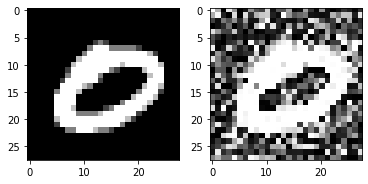

25  :  0.2444780234073941 25
50  :  0.4329933552160965 25
75  :  0.41693570150370046 25
100  :  0.45578828452490033 25
125  :  0.4711016205611988 25
150  :  0.48511872698174885 25
175  :  0.4862155956944555 25
200  :  0.48812157171890175 25
225  :  0.48793679323573796 25
250  :  0.48830842237881966 25
275  :  0.4883441266049083 25
300  :  0.48874035429228646 25
325  :  0.4890460179846619 25
350  :  0.4894587098852582 25
375  :  0.4892432657113969 25


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide


400  :  0.4896877889194737 25
425  :  0.48965357074219223 25
450  :  0.49049879680808606 25
475  :  0.49040039231429433 25
500  :  0.49037735804812294 25
525  :  0.49056847727356206 25
550  :  0.4908624558364847 25
575  :  0.4908656520956036 25
600  :  0.49092962586539185 25
625  :  0.490926712084176 25
650  :  0.49090412927428684 25
675  :  0.49090412927428684 25
700  :  0.4912409578613161 25
725  :  0.491255277834388 25
750  :  0.4915119879710619 25
775  :  0.4914521227791612 25
800  :  0.4915038678482498 25
825  :  0.49151032477157985 25
850  :  0.49154175540471345 25
875  :  0.49163789041859585 25
900  :  0.49164854013629783 25
925  :  0.491810674042531 25
Time:  89.2231457233429  seconds
Predicted class:  [5]


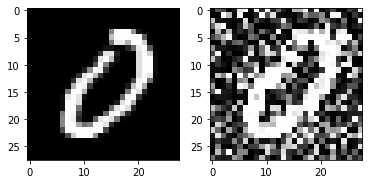

25  :  0.4448078539312895 25
50  :  0.48490855011533884 25
75  :  0.48554109090154546 25
100  :  0.4833016136116791 25
125  :  0.48764008355892596 25
150  :  0.4888564964746768 25
175  :  0.4886376904215733 25
200  :  0.4896868243760138 25
225  :  0.4901561655876596 25
250  :  0.4904376240793629 25
275  :  0.4905645359622651 25
300  :  0.4908735766734451 25
325  :  0.49145071959163195 25
350  :  0.49124987723098096 25
375  :  0.49124987723098096 25
400  :  0.4913858854806555 25
425  :  0.49178982861855586 25
450  :  0.4919316665690649 25
475  :  0.49184510017288374 25
500  :  0.49196965571848816 25
525  :  0.4919712594927496 25
550  :  0.49209357638328993 25
575  :  0.49214637043936293 25
600  :  0.49216130652722495 25
625  :  0.49222523675241253 25
650  :  0.49227318612974696 25
675  :  0.4923847432662339 25
700  :  0.49247372997021854 25
725  :  0.492467472996793 25
750  :  0.4925498370112603 25
775  :  0.4926236865005161 25
800  :  0.49262109310062524 25
825  :  0.4926893260126279 2

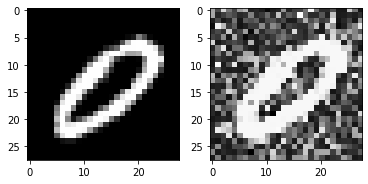

25  :  0.31144832497681046 25
50  :  0.48695409425471914 25
75  :  0.4613011176419944 25
100  :  0.48124069714368073 25
125  :  0.48906525314563787 25
150  :  0.4892023310926653 25
175  :  0.48929240389564094 25
200  :  0.49068756106765543 25
225  :  0.49081807448900444 25
250  :  0.491125336930912 25
275  :  0.491138531551026 25
300  :  0.4914913909209801 25
325  :  0.4916027979507083 25
350  :  0.49156397360054443 25
375  :  0.49164775502402663 25
400  :  0.49175926017723826 25
425  :  0.49191120539639716 25
450  :  0.4919870262616119 25
475  :  0.49206305114431953 25
500  :  0.4923216615070751 25
525  :  0.49243672510845443 25
550  :  0.4924490414821497 25
575  :  0.4924755864695753 25
600  :  0.4925449555685356 25
625  :  0.49255841325307476 25
650  :  0.49277614894446015 25
675  :  0.4927746851112575 25
700  :  0.49279550670309097 25
725  :  0.4928691413150064 25
750  :  0.4928975987958947 25
775  :  0.49294007276251656 25
800  :  0.4930198197293475 25
825  :  0.49301953075859795 

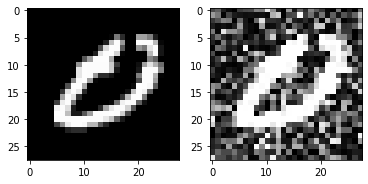

25  :  0.04164307701854287 25
50  :  0.4389989511726852 25
75  :  0.2318623010032903 25
100  :  0.3709984822380686 25
125  :  0.36295242601210803 25
150  :  0.4599071892470666 25
175  :  0.4726714252146667 25
200  :  0.4821159018394147 25
225  :  0.4855278789918763 25
250  :  0.48936184867770416 25
275  :  0.48898453554433946 25
300  :  0.489247664865248 25
325  :  0.48964609195201525 25
350  :  0.4898063665698386 25
375  :  0.4898063665698386 25
400  :  0.49035431893363784 25
425  :  0.4902568363723628 25
450  :  0.490353170264869 25
475  :  0.49058186611638693 25
500  :  0.49061959603091304 25
525  :  0.4907446595551548 25
550  :  0.4907446595551548 25
575  :  0.4908146622969107 25
600  :  0.4908623545380851 25
625  :  0.490966152363261 25
650  :  0.49103341368303827 25
675  :  0.49104662631278556 25
700  :  0.49115800934428483 25
725  :  0.49122144710054927 25
750  :  0.4912468263200683 25
775  :  0.4913249913385744 25
800  :  0.49133308867093595 25
825  :  0.4914151168869603 25
850

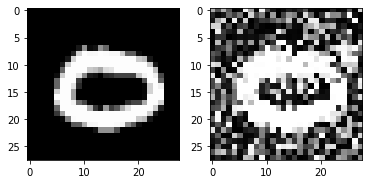

25  :  -0.2953444622416892 25
50  :  0.4266884164652454 25
75  :  0.26457754097065717 25
100  :  0.38944555022417415 25
125  :  0.431403872384731 25
150  :  0.4738077445810136 25
175  :  0.4816565251355866 25
200  :  0.48403543560423945 25
225  :  0.4856516802774596 25
250  :  0.48441048455196317 25
275  :  0.4854742510624183 25
300  :  0.48397335191706664 25
325  :  0.48581745963664913 25
350  :  0.48717462593795363 25
375  :  0.4874022328968897 25
400  :  0.48755235998711044 25
425  :  0.4878171684727683 25
450  :  0.48817882565230775 25
475  :  0.4883139657583943 25
500  :  0.4888596248906926 25
525  :  0.4888596248906926 25
550  :  0.48901476761262386 25
575  :  0.48901476761262386 25
600  :  0.4892398123539448 25
625  :  0.48933747985237347 25
650  :  0.48935878305603203 25
675  :  0.4893833471145394 25
700  :  0.48940037240171136 25
725  :  0.489438454830127 25
750  :  0.4894509086276638 25
775  :  0.48956437605155617 25
800  :  0.489589309577229 25
825  :  0.48971647776034893 25

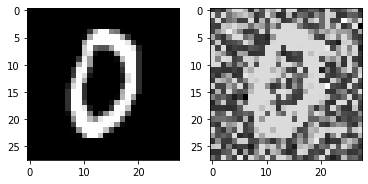

25  :  0.017480351271905236 25
50  :  0.3952137132331949 25
75  :  0.3152698591330702 25
100  :  0.39454722701689315 25
125  :  0.4630125432262111 25
150  :  0.48168713096080734 25
175  :  0.4832094234629374 25
200  :  0.4836927913465062 25
225  :  0.4860112725922313 25
250  :  0.4859147252439571 25
275  :  0.48693458801414513 25
300  :  0.4879237035541101 25
325  :  0.4879727762315538 25
350  :  0.4880416156025657 25
375  :  0.4889987553004943 25
400  :  0.4889987553004943 25
425  :  0.48900385456514467 25
450  :  0.48961925787586813 25
475  :  0.48976700831951314 25
500  :  0.48976700831951314 25
525  :  0.4898131464560375 25
550  :  0.4899192094361851 25
575  :  0.49003620941877085 25
600  :  0.49003620941877085 25
625  :  0.49026184325453653 25
650  :  0.4902422103295945 25
675  :  0.4902422103295945 25
700  :  0.49030627200824034 25
725  :  0.4904191367875115 25
750  :  0.490421788420516 25
775  :  0.4904260469575146 25
800  :  0.49047937114396606 25
825  :  0.49047937114396606 25

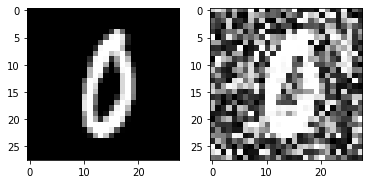

25  :  -0.19917626252344617 25
50  :  0.4017991840365365 25
75  :  0.018360212711139707 25
100  :  0.31170400565244305 25
125  :  0.40347811028572445 25
150  :  0.42352712836210815 25
175  :  0.4687088415329409 25
200  :  0.4852099997882837 25
225  :  0.4860751177470736 25
250  :  0.4865318261061834 25
275  :  0.4872547905196887 25
300  :  0.487395351992769 25
325  :  0.4875841782663855 25
350  :  0.48816698127963115 25
375  :  0.48943073706552365 25
400  :  0.4896742577481363 25
425  :  0.49024506492652253 25
450  :  0.49020668893071867 25
475  :  0.49025869093384444 25
500  :  0.4903417333753737 25
525  :  0.49037332865437727 25
550  :  0.49037332865437727 25
575  :  0.4905742689495736 25
600  :  0.4905741843081348 25
625  :  0.4905882599103338 25
650  :  0.4907764511093496 25
675  :  0.4907398772307304 25
700  :  0.49091223717527227 25
725  :  0.4908987735696008 25
750  :  0.49094379551748324 25
775  :  0.49095121014109794 25
800  :  0.49109134727484144 25
825  :  0.4911076415779808

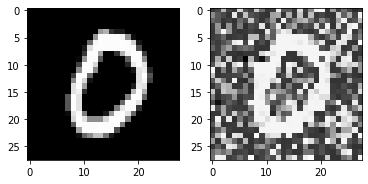

25  :  0.4874140704054071 25
50  :  0.4919069769735756 25
75  :  0.49249882494287844 25
100  :  0.4925944822031512 25
125  :  0.492928702740818 25
150  :  0.4933585122287132 25
175  :  0.49341702714609725 25
200  :  0.49351294238704346 25
225  :  0.49423996505332474 25
250  :  0.49411661722406247 25
275  :  0.4941607488231336 25
300  :  0.49418152385279573 25
325  :  0.49417064586691706 25
350  :  0.49414415217174007 25
375  :  0.4943518332588425 25
400  :  0.4943518332588425 25
425  :  0.49437662747509936 25
450  :  0.4944098444412594 25
475  :  0.4944508862612165 25
500  :  0.49448060166279706 25
525  :  0.49452308329781397 25
550  :  0.49461611063701716 25
575  :  0.494668838012019 25
600  :  0.4947795692904278 25
625  :  0.4948067086696568 25
650  :  0.49481744265909694 25
675  :  0.4948500770649963 25
700  :  0.49487104737624305 25
725  :  0.4948740656481804 25
750  :  0.49491445052775723 25
775  :  0.49491452598845836 25
800  :  0.4949353997773669 25
Time:  76.57281136512756  sec

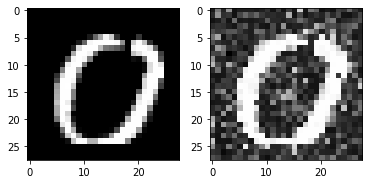

25  :  -0.3610133353074485 25
50  :  0.2686520464079759 25
75  :  0.1140679217336738 25
100  :  0.38109827948651886 25
125  :  0.3449361113634699 25
150  :  0.45130079045723664 25
175  :  0.47828270096174036 25
200  :  0.48306778129498706 25
225  :  0.48390176645046185 25
250  :  0.4856581734653176 25
275  :  0.4857158242835645 25
300  :  0.48631514313137103 25
325  :  0.4861304578086232 25
350  :  0.4866488755785773 25
375  :  0.48694790620476547 25
400  :  0.48737608696106466 25
425  :  0.4876262226015246 25
450  :  0.48817707017022455 25
475  :  0.48871715779676683 25
500  :  0.48858820331075425 25
525  :  0.48876111980711157 25
550  :  0.48885217152103033 25
575  :  0.4891732532915751 25
600  :  0.4895306528398208 25
625  :  0.48954729862387214 25
650  :  0.4897649659282215 25
675  :  0.4899230746663087 25
700  :  0.49003494785416657 25
725  :  0.4900689526015833 25
750  :  0.4902037542949778 25
775  :  0.49039344191049494 25
800  :  0.4904150220732705 25
825  :  0.4904260961697873

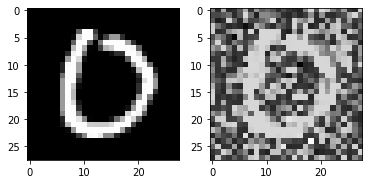

25  :  0.478774183768804 25
50  :  0.4806620736119732 25
75  :  0.47637009623619586 25
100  :  0.4808173465798332 25
125  :  0.4841263489260621 25
150  :  0.49055845185389474 25
175  :  0.49417958661661404 25
200  :  0.4944179970186049 25
225  :  0.4945231191682978 25
250  :  0.49500264890375456 25
275  :  0.4956226596303384 25
300  :  0.4960098977869452 25
325  :  0.4960127199044169 25
350  :  0.4960127199044169 25
375  :  0.4960127199044169 25
400  :  0.4960127199044169 25
425  :  0.4960127199044169 25
450  :  0.49612499333106747 25
475  :  0.49616858144091186 25
500  :  0.4961691367472081 25
525  :  0.4963363721458806 25
550  :  0.4963364345038094 25
575  :  0.4963837511961625 25
600  :  0.4963863966389987 25
625  :  0.4964681246478514 25
650  :  0.49647036692793306 25
675  :  0.4965066705661351 25
700  :  0.4965240759139502 25
725  :  0.49658690291213026 25
750  :  0.496599214471969 25
775  :  0.49664137066443487 25
800  :  0.4966576704743897 25
Time:  70.81853699684143  seconds
Pr

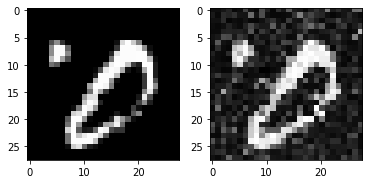

25  :  -0.3738291143499146 25
50  :  -0.05306227647823797 25
75  :  -0.08007779186100253 25
100  :  0.3057094838469098 25
125  :  0.45530612390039465 25
150  :  0.4640808731271291 25
175  :  0.4640808731271291 25
200  :  0.46474586081257785 25
225  :  0.4751519872024181 25
250  :  0.47627565797957394 25
275  :  0.48375364558379763 25
300  :  0.4837612861972528 25
325  :  0.486236067610991 25
350  :  0.486236067610991 25
375  :  0.486236067610991 25
400  :  0.48755049070450407 25
425  :  0.4883691634311285 25
450  :  0.4902295941538963 25
475  :  0.4901948262780264 25
500  :  0.4910223615321554 25
525  :  0.4919848308929869 25
550  :  0.4925261789250884 25
575  :  0.49273717398847716 25
600  :  0.4928925065771734 25
625  :  0.4931726658310612 25
650  :  0.4936457418717563 25
675  :  0.4936641236655443 25
700  :  0.4942826053248159 25
725  :  0.4942826053248159 25
750  :  0.49431008117524644 25
775  :  0.49443627094687626 25
800  :  0.4945488102689052 25
825  :  0.4947060594552227 25
850

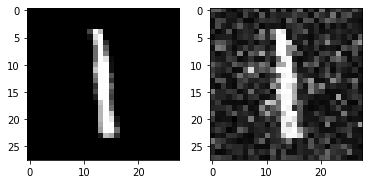

25  :  -0.44316198849373717 25
50  :  0.09017693639770037 25
75  :  0.17442172072650255 25
100  :  0.30995054234424535 25
125  :  0.44206921222066065 25
150  :  0.4730635294790656 25
175  :  0.47756487086346533 25
200  :  0.47756487086346533 25
225  :  0.47756487086346533 25
250  :  0.4810936431501444 25
275  :  0.48042056227574664 25
300  :  0.48214223223344543 25
325  :  0.48564418417267896 25
350  :  0.48644074602766874 25
375  :  0.4874502614414673 25
400  :  0.4870747907167403 25
425  :  0.48842083010864284 25
450  :  0.48905780438848484 25
475  :  0.4913450595428744 25
500  :  0.4923990170692224 25
525  :  0.4927568501967666 25
550  :  0.49268335605282515 25
575  :  0.49268335605282515 25
600  :  0.49268335605282515 25
625  :  0.49278576123369244 25
650  :  0.4930423528000371 25
675  :  0.49332662199236527 25
700  :  0.493294428696709 25
725  :  0.49332656612096104 25
750  :  0.49347956513968066 25
775  :  0.49358532599928157 25
800  :  0.4936810593597401 25
825  :  0.49373211184

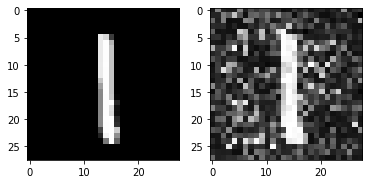

25  :  -0.37486926386081815 25
50  :  0.14527026926067946 25
75  :  0.24296258734946327 25
100  :  0.4140919742127277 25
125  :  0.476513555132489 25
150  :  0.48449646272068353 25
175  :  0.4877855718443143 25
200  :  0.4906256945836079 25
225  :  0.49221888923722457 25
250  :  0.4921912339306269 25
275  :  0.49290830197209773 25
300  :  0.49310886524692044 25
325  :  0.49307047471041154 25
350  :  0.4931715885885241 25
375  :  0.4938415358967595 25
400  :  0.4941571265084622 25
425  :  0.4943258208270362 25
450  :  0.4944352345418402 25
475  :  0.4944089203213424 25
500  :  0.4944728635091089 25
525  :  0.4945847913668824 25
550  :  0.49458396016096273 25
575  :  0.49465189581781444 25
600  :  0.4947253126717217 25
625  :  0.49477558071072025 25
650  :  0.4948107033731954 25
675  :  0.4948196336224412 25
700  :  0.4948422620084895 25
725  :  0.49484847552898414 25
750  :  0.4949243395576075 25
775  :  0.49492564597778743 25
800  :  0.49492564597778743 25
825  :  0.49495164643485945 2

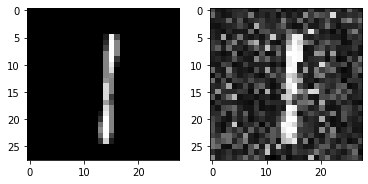

25  :  -0.48515008914097296 25
50  :  -0.4114754047829925 25
75  :  -0.33304922818792315 25
100  :  -0.04286247748194863 25
125  :  0.383748104336991 25
150  :  0.45496037923577076 25
175  :  0.47299405134442213 25
200  :  0.4798705502500181 25
225  :  0.4808162758840515 25
250  :  0.483879610993213 25
275  :  0.483879610993213 25
300  :  0.485702710028439 25
325  :  0.48580640822411075 25
350  :  0.4896278088555641 25
375  :  0.4905066767905553 25
400  :  0.49071959465941184 25
425  :  0.49071959465941184 25
450  :  0.49071959465941184 25
475  :  0.49128725264872963 25
500  :  0.4915879253094713 25
525  :  0.49161261987586313 25
550  :  0.49162765316389884 25
575  :  0.4918880270971151 25
600  :  0.4923779097443453 25
625  :  0.4926498120525401 25
650  :  0.4929495920072428 25
675  :  0.4932132464567768 25
700  :  0.4932396338595533 25
725  :  0.4935084011299734 25
750  :  0.49360321645783406 25
775  :  0.49372596028237875 25
800  :  0.49388704704518493 25
825  :  0.4940214938547164 2

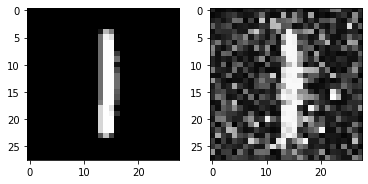

25  :  -0.3658597236826871 25
50  :  -0.15036620558704067 25
75  :  -0.08115121748093172 25
100  :  0.18198207321960316 25
125  :  0.38729202677337665 25
150  :  0.4300721285714001 25
175  :  0.436176376414671 25
200  :  0.44234731486198736 25
225  :  0.44234731486198736 25
250  :  0.45551175519517123 25
275  :  0.45992623726120013 25
300  :  0.46137120780744084 25
325  :  0.4699312339873221 25
350  :  0.4799395176920157 25
375  :  0.4885181619145855 25
400  :  0.4884946113917425 25
425  :  0.4884946113917425 25
450  :  0.4899648569622412 25
475  :  0.49023871353163057 25
500  :  0.4927308153634342 25
525  :  0.49236295884776654 25
550  :  0.4940906531498118 25
575  :  0.49403140216349406 25
600  :  0.49403140216349406 25
625  :  0.49442300870939976 25
650  :  0.4946908218148454 25
675  :  0.49488784822897913 25
700  :  0.4949023629269936 25
725  :  0.4949023629269936 25
750  :  0.49498046405427215 25
775  :  0.4950793344374676 25
800  :  0.49510694573519975 25
825  :  0.49523792541116

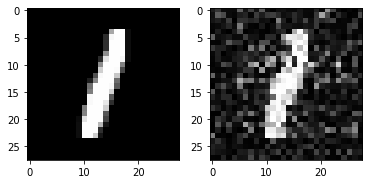

25  :  -0.14088244375920556 25
50  :  0.08200177788100597 25
75  :  0.3773422678526868 25
100  :  0.3553705315218423 25
125  :  0.4023475231318348 25
150  :  0.440956389662249 25
175  :  0.4133684869993981 25
200  :  0.46778599241778596 25
225  :  0.4504498432674694 25
250  :  0.45157595218271807 25
275  :  0.45094094138494206 25
300  :  0.45094094138494206 25
325  :  0.4531239096459926 25
350  :  0.45516382796889276 25
375  :  0.46041066610401693 25
400  :  0.46026751946457906 25
425  :  0.46262538596818875 25
450  :  0.46262538596818875 25
475  :  0.4724929521498674 25
500  :  0.4724929521498674 25
525  :  0.47277144657673825 25
550  :  0.4734156185444286 25
575  :  0.4756402484956887 25
600  :  0.4770407290472139 25
625  :  0.4801162177994895 25
650  :  0.482106689250074 25
675  :  0.4823725677188675 25
700  :  0.4862025126298837 25
725  :  0.4862931930410667 25
750  :  0.4862931930410667 25
775  :  0.48666536937892513 25
800  :  0.48691351391436777 25
825  :  0.48796421778278154 25

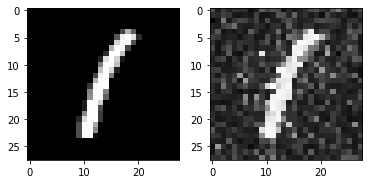

25  :  0.2330771674210705 25
50  :  0.31544466146881933 25
75  :  0.3109782596794337 25
100  :  0.3733121138279075 25
125  :  0.41661141566176857 25
150  :  0.43899658805653846 25
175  :  0.4562003236445274 25
200  :  0.4440938714975904 25
225  :  0.4647308945383353 25
250  :  0.46927841683215615 25
275  :  0.48197034420330964 25
300  :  0.4716139439001422 25
325  :  0.4708377291676282 25
350  :  0.4848539780625377 25
375  :  0.4810027113503983 25
400  :  0.48097480763699074 25
425  :  0.4792551458328317 25
450  :  0.48471483255013353 25
475  :  0.4867849555263356 25
500  :  0.4891145946548823 25
525  :  0.4892391738416165 25
550  :  0.4917977409012809 25
575  :  0.49097776634246 25
600  :  0.4920050450454253 25
625  :  0.4935020985068082 25
650  :  0.4938589889787166 25
675  :  0.4935041700712493 25
700  :  0.4943280656527649 25
725  :  0.49448833185137114 25
750  :  0.49462750461082317 25
775  :  0.49521544953196417 25
800  :  0.49521544953196417 25
825  :  0.4952907501004174 25
850 

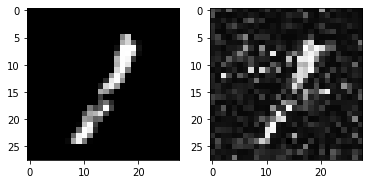

25  :  0.055919433276245295 25
50  :  0.3940556129622272 25
75  :  0.4554833482695426 25
100  :  0.4626257774632057 25
125  :  0.45917134035161133 25
150  :  0.4662161860802925 25
175  :  0.47022784843516574 25
200  :  0.48404131017057406 25
225  :  0.48521262764389556 25
250  :  0.48432496238403233 25
275  :  0.4846756747749455 25
300  :  0.4857089364179958 25
325  :  0.4842832783913552 25
350  :  0.48658362059793925 25
375  :  0.4875383345074952 25
400  :  0.488181508736616 25
425  :  0.4892878933657899 25
450  :  0.4886427741329286 25
475  :  0.48900697384849856 25
500  :  0.4890431828627331 25
525  :  0.48855935595219696 25
550  :  0.4888467613906849 25
575  :  0.48963597919070395 25
600  :  0.48977272998126786 25
625  :  0.4899634429822083 25
650  :  0.4898483260238734 25
675  :  0.4898975119909168 25
700  :  0.4900486525209193 25
725  :  0.4902707953341626 25
750  :  0.4903596641948571 25
775  :  0.49037925708823615 25
800  :  0.4904627800698905 25
825  :  0.4905407293954711 25
8

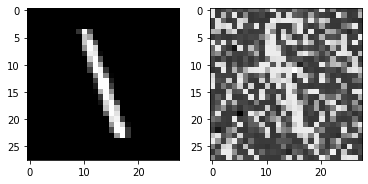

25  :  -0.33638823543591595 25
50  :  0.43115830636376673 25
75  :  0.3897457742767427 25
100  :  0.44885411743188897 25
125  :  0.4610299554648425 25
150  :  0.47135943334837943 25
175  :  0.4844329586542539 25
200  :  0.4862633862578239 25
225  :  0.4886620464648984 25
250  :  0.48953638080130385 25
275  :  0.4900407096041582 25
300  :  0.4903882191287242 25
325  :  0.4912341885600711 25
350  :  0.4912341885600711 25
375  :  0.4912341885600711 25
400  :  0.4912341885600711 25
425  :  0.4912341885600711 25
450  :  0.4913594413282748 25
475  :  0.4913594413282748 25
500  :  0.49144703412834734 25
525  :  0.4914791661893614 25
550  :  0.4914791661893614 25
575  :  0.4915715901622157 25
600  :  0.491559830451139 25
625  :  0.491559830451139 25
650  :  0.49161281817590463 25
675  :  0.4916319159000243 25
700  :  0.4916319159000243 25
725  :  0.49171602198111586 25
750  :  0.49173371306839503 25
775  :  0.4917677848761583 25
800  :  0.4917844152145152 25
825  :  0.4917976985646215 25
850  

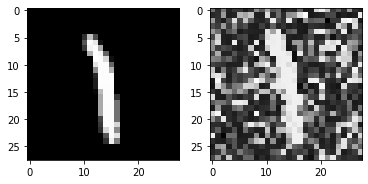

25  :  -0.4856573101145394 25
50  :  -0.4397980499000976 25
75  :  -0.35572575897046166 25
100  :  0.00037518088943425815 25
125  :  0.35471791228888894 25
150  :  0.4240661517929943 25
175  :  0.4566495751111141 25
200  :  0.4828905217217102 25
225  :  0.4846552679870026 25
250  :  0.4838771699306236 25
275  :  0.485850085507731 25
300  :  0.48616962101968014 25
325  :  0.4875309668178629 25
350  :  0.48797640796091357 25
375  :  0.48738888458628915 25
400  :  0.488006483652807 25
425  :  0.4881439416522909 25
450  :  0.4884441338180347 25
475  :  0.4888496047293328 25
500  :  0.4891169397651268 25
525  :  0.48905349456431885 25
550  :  0.48911414190946 25
575  :  0.48912409074316343 25
600  :  0.48916739751678734 25
625  :  0.48917129061116654 25
650  :  0.4895025904711237 25
675  :  0.4895025904711237 25
700  :  0.489627666014231 25
725  :  0.489693007532759 25
750  :  0.4896755165908238 25
775  :  0.4897705252288597 25
800  :  0.4898689722352981 25
825  :  0.48987963768688336 25
85

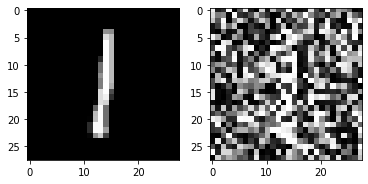

25  :  -0.478798336782368 25
50  :  -0.34629293061011257 25
75  :  0.021959815751120156 25
100  :  0.1654226576405195 25
125  :  0.35121542378379816 25
150  :  0.3830857004988285 25
175  :  0.4153501722024981 25
200  :  0.4231405508912107 25
225  :  0.4274619935046952 25
250  :  0.44195964455797476 25
275  :  0.4474683864969508 25
300  :  0.4511698396861776 25
325  :  0.45847948680197126 25
350  :  0.46020357094741693 25
375  :  0.46554391662242517 25
400  :  0.4668697442506419 25
425  :  0.47031382156271373 25
450  :  0.47031382156271373 25
475  :  0.47464657712714625 25
500  :  0.47596117669152094 25
525  :  0.4762786072305661 25
550  :  0.47793020643483247 25
575  :  0.4808167795151677 25
600  :  0.48166739806134645 25
625  :  0.4831569950377492 25
650  :  0.4831873985620817 25
675  :  0.4832753944666208 25
700  :  0.4843837567376453 25
725  :  0.48456495793654086 25
750  :  0.48516797903123277 25
775  :  0.48516499895480275 25
800  :  0.48569822399811624 25
825  :  0.48763293519657

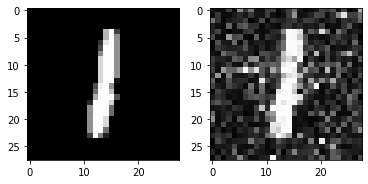

25  :  -0.4748234496340405 25
50  :  -0.4748234496340405 25
75  :  -0.3924007377084303 25
100  :  -0.25751883855419233 25
125  :  0.1324762133056198 25
150  :  0.24794112758913056 25
175  :  0.38199483214301966 25
200  :  0.3923444628455628 25
225  :  0.436638788860805 25
250  :  0.44466278024466355 25
275  :  0.44466278024466355 25
300  :  0.44466278024466355 25
325  :  0.44466278024466355 25
350  :  0.44466278024466355 25
375  :  0.44466278024466355 25
400  :  0.4517579756919938 25
425  :  0.4577746027892558 25
450  :  0.4655397792179973 25
475  :  0.4659836828021304 25
500  :  0.4735659886958846 25
525  :  0.47527425665959466 25
550  :  0.47522805385612704 25
575  :  0.47522805385612704 25
600  :  0.47944855512617074 25
625  :  0.47993070717449904 25
650  :  0.4813184718727104 25
675  :  0.48116467535931584 25
700  :  0.48116467535931584 25
725  :  0.4816731313993256 25
750  :  0.4829825453934516 25
775  :  0.48319726490171727 25
800  :  0.4855166488275441 25
825  :  0.4857216386745

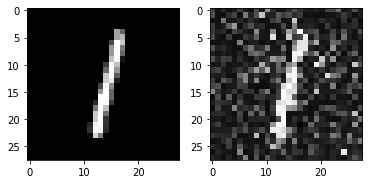

25  :  -0.46718767179540893 25
50  :  -0.4227111546819742 25
75  :  -0.19910643821071422 25
100  :  0.08349201570670804 25
125  :  0.30959396989315724 25
150  :  0.3672765134275578 25
175  :  0.3672765134275578 25
200  :  0.40719244189641796 25
225  :  0.4194413900907213 25
250  :  0.45384768311549284 25
275  :  0.4230747699380143 25
300  :  0.45416110086783873 25
325  :  0.45416110086783873 25
350  :  0.4549974408823173 25
375  :  0.458542224048861 25
400  :  0.4724536257825505 25
425  :  0.4820138956245778 25
450  :  0.4791792601835094 25
475  :  0.48404674023202493 25
500  :  0.4860437367131895 25
525  :  0.4877942658402488 25
550  :  0.4890389605291488 25
575  :  0.48941959660702866 25
600  :  0.4897026465025753 25
625  :  0.4897937649023753 25
650  :  0.49009106462166924 25
675  :  0.4899192913373246 25
700  :  0.49075717301519517 25
725  :  0.49130294261163127 25
750  :  0.49140521624995287 25
775  :  0.4915579234327756 25
800  :  0.49191522646690367 25
825  :  0.4919339117523572

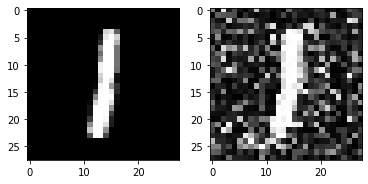

25  :  -0.3188580764062244 25
50  :  0.04958088405168855 25
75  :  -0.025210389046108575 25
100  :  0.20230428966866087 25
125  :  0.34655968469419907 25
150  :  0.3620935955029845 25
175  :  0.37242457508496435 25
200  :  0.4003160460912609 25
225  :  0.4025538537425005 25
250  :  0.43658998260934173 25
275  :  0.4521751033500093 25
300  :  0.451442895855416 25
325  :  0.451442895855416 25
350  :  0.4616911651787061 25
375  :  0.4675050167315022 25
400  :  0.4690164109129217 25
425  :  0.471466978457538 25
450  :  0.4743306129338071 25
475  :  0.47825770557090064 25
500  :  0.48226824809779434 25
525  :  0.4822677713807415 25
550  :  0.4832231908498144 25
575  :  0.48421959410949106 25
600  :  0.4845029688690509 25
625  :  0.4855968716825493 25
650  :  0.4861689208979874 25
675  :  0.48628023669753506 25
700  :  0.4864520470826923 25
725  :  0.4873007522847724 25
750  :  0.48817817179544976 25
775  :  0.4889482867266883 25
800  :  0.48894379215294986 25
825  :  0.48996371321267096 25


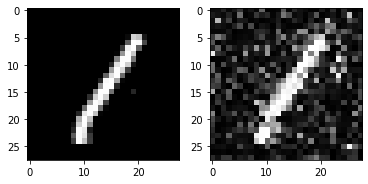

25  :  -0.4747739733206745 25
50  :  -0.4412973649079189 25
75  :  -0.2699661030285211 25
100  :  -0.20973026255848112 25
125  :  0.1685332738235588 25
150  :  0.23712031805770245 25
175  :  0.37407970565856563 25
200  :  0.38005950408614086 25
225  :  0.3720534279764891 25
250  :  0.4704022870248334 25
275  :  0.4744816944969485 25
300  :  0.4753779399442829 25
325  :  0.4824244937298369 25
350  :  0.48491317986977417 25
375  :  0.48448536525785785 25
400  :  0.4849291201254726 25
425  :  0.4863361682532903 25
450  :  0.4862647631601441 25
475  :  0.4861177554643365 25
500  :  0.48664311111404174 25
525  :  0.4865233642122829 25
550  :  0.486427303636947 25
575  :  0.48659288768935216 25
600  :  0.48731489353023 25
625  :  0.4871812763942016 25
650  :  0.48737128824107917 25
675  :  0.48777405580905014 25
700  :  0.4877352716561152 25
725  :  0.48773827222356536 25
750  :  0.48782415767025883 25
775  :  0.48812652917842564 25
800  :  0.48801381015073064 25
825  :  0.4881815415260404 2

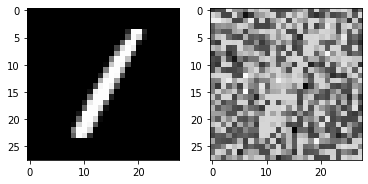

25  :  -0.49391640531817793 25
50  :  -0.33182288811667393 25
75  :  -0.33518548648002056 25
100  :  -0.265641068302071 25
125  :  -0.04576032607395489 25
150  :  0.20641797815046894 25
175  :  0.4203244437976184 25
200  :  0.4711680772787733 25
225  :  0.4843749849910263 25
250  :  0.4843208026697835 25
275  :  0.483582092871693 25
300  :  0.48275640649458246 25
325  :  0.4840559071358797 25
350  :  0.4836507060986342 25
375  :  0.48445015194468966 25
400  :  0.4846856431194241 25
425  :  0.4848051575933045 25
450  :  0.4861008088505214 25
475  :  0.4863778239206194 25
500  :  0.48692018718060814 25
525  :  0.4865613365374071 25
550  :  0.48724319145475514 25
575  :  0.48706373166139627 25
600  :  0.4875763333878619 25
625  :  0.48751512037497596 25
650  :  0.48773039539302104 25
675  :  0.48791160935183225 25
700  :  0.4878935948952606 25
725  :  0.48788880106018817 25
750  :  0.4881733871479265 25
775  :  0.4881848345056497 25
800  :  0.48830221951437436 25
825  :  0.488444848323432

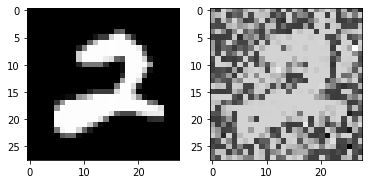

25  :  -0.45080281481625006 25
50  :  0.4089835272264652 25
75  :  -0.1783734190913902 25
100  :  -0.17923534803359842 25
125  :  0.2143745636554987 25
150  :  0.391502241778485 25
175  :  0.46725074467715505 25
200  :  0.47953323571881384 25
225  :  0.4803992570221182 25
250  :  0.4826260316892363 25
275  :  0.48254180700780397 25
300  :  0.4834390908681051 25
325  :  0.4839542991808493 25
350  :  0.48425980794287893 25
375  :  0.4846893609279215 25
400  :  0.486158077386552 25
425  :  0.4861782243692871 25
450  :  0.4862578436436086 25
475  :  0.48710007368122976 25
500  :  0.4872920163354144 25
525  :  0.4877172510149751 25
550  :  0.48805106696642536 25
575  :  0.48821632613935967 25
600  :  0.4882389542128149 25
625  :  0.4883218770350431 25
650  :  0.4883335090706588 25
675  :  0.48885049896087324 25
700  :  0.48891935400111214 25
725  :  0.48891935400111214 25
750  :  0.4890679793521782 25
775  :  0.48926972831946935 25
800  :  0.4894375080632501 25
825  :  0.48939682267153023 2

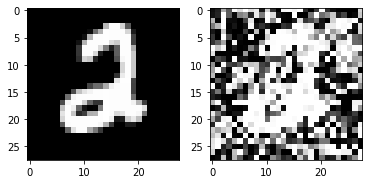

25  :  -0.22460985340560308 25
50  :  -0.2207567627657014 25
75  :  -0.171038902842169 25
100  :  -0.1072401821773454 25
125  :  -0.11474764730372358 25
150  :  -0.08231050931640399 25
175  :  -0.050425292663756074 25
200  :  0.0024156586526767393 25
225  :  0.25295357660114826 25
250  :  0.2564196416595436 25
275  :  0.27494889766063224 25
300  :  0.38113356749995697 25
325  :  0.44294405469504594 25
350  :  0.4868985395592958 25
375  :  0.48819660912438595 25
400  :  0.4886007545261146 25
425  :  0.4878876561835781 25
450  :  0.48826821074249444 25
475  :  0.4872640643075555 25
500  :  0.48860824754254384 25
525  :  0.48900795625403176 25
550  :  0.48965449882995604 25
575  :  0.4901176574785835 25
600  :  0.4904888000146865 25
625  :  0.4909238653950523 25
650  :  0.4907605115945386 25
675  :  0.4907747947426528 25
700  :  0.49081855138762637 25
725  :  0.49095552325128494 25
750  :  0.4910773474216638 25
775  :  0.4911720158064974 25
800  :  0.49126097477573044 25
825  :  0.4912697

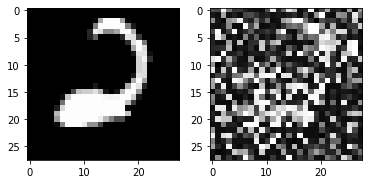

25  :  -0.4504564245583746 25
50  :  -0.36948456430051724 25
75  :  -0.409861404379951 25
100  :  -0.35282838336758715 25
125  :  -0.306065207090888 25
150  :  -0.07239249176159972 25
175  :  0.2014264117425799 25
200  :  0.3352552769852359 25
225  :  0.4525413998009235 25
250  :  0.481558145773999 25
275  :  0.479352070707869 25
300  :  0.48092968712004946 25
325  :  0.4815984323387098 25
350  :  0.4841122597907267 25
375  :  0.48286687295437974 25
400  :  0.4829199466332877 25
425  :  0.4840962392756286 25
450  :  0.48452611857782996 25
475  :  0.48509371129297757 25
500  :  0.48544037038371224 25
525  :  0.4858980216564815 25
550  :  0.48614349222596615 25
575  :  0.48643370318994933 25
600  :  0.48646789729449963 25
625  :  0.48671742867617 25
650  :  0.4868693008821043 25
675  :  0.4869561077132127 25
700  :  0.48705793975580264 25
725  :  0.48725476495455566 25
750  :  0.4873274823173224 25
775  :  0.4874931772736723 25
800  :  0.48765657581117855 25
825  :  0.48773732837204387 2

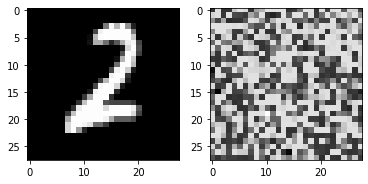

25  :  0.24913003785751583 25
50  :  0.45946382369634364 25
75  :  0.42558012159055647 25
100  :  0.4063612034872681 25
125  :  0.4586216978923955 25
150  :  0.4706312854782697 25
175  :  0.4826919345090773 25
200  :  0.4851696403710659 25
225  :  0.4844180597777565 25
250  :  0.4849073606012012 25
275  :  0.4866719066384565 25
300  :  0.4858865380684099 25
325  :  0.4863483582058773 25
350  :  0.4871180067566761 25
375  :  0.4872561177528568 25
400  :  0.487446085784587 25
425  :  0.4878075577046289 25
450  :  0.4880556389059095 25
475  :  0.48809945169530566 25
500  :  0.48858138328779316 25
525  :  0.48894854812426697 25
550  :  0.48902729025043185 25
575  :  0.48917175546174 25
600  :  0.489384488738169 25
625  :  0.4895117983888517 25
650  :  0.48984584931290287 25
675  :  0.48985584863434667 25
700  :  0.4899680549123634 25
725  :  0.4900705203473382 25
750  :  0.49020519207785235 25
775  :  0.4902806647658539 25
800  :  0.49033647965513005 25
825  :  0.4903761006956283 25
850  :

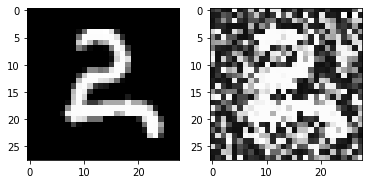

25  :  -0.04991713474558199 25
50  :  -0.007082084101520489 25
75  :  0.03567832533507481 25
100  :  0.15317839738252187 25
125  :  0.2782760055981454 25
150  :  0.3842124380952186 25
175  :  0.4389811814559746 25
200  :  0.4650792761284718 25
225  :  0.4660742370319694 25
250  :  0.485335779978122 25
275  :  0.48410912421442337 25
300  :  0.48667689008552045 25
325  :  0.490191382072024 25
350  :  0.49036596335567945 25
375  :  0.4917071926459978 25
400  :  0.4918028839525863 25
425  :  0.49375046895959446 25
450  :  0.4941237688427434 25
475  :  0.49412721851078356 25
500  :  0.49412721851078356 25
525  :  0.4941278212888965 25
550  :  0.49450434894305384 25
575  :  0.49463621498594745 25
600  :  0.4947180011059437 25
625  :  0.4947180011059437 25
650  :  0.4947180011059437 25
675  :  0.495005837609338 25
700  :  0.4950364233363109 25
725  :  0.4950664703525998 25
750  :  0.49509560885462434 25
775  :  0.49531098283529107 25
800  :  0.4955252944388068 25
825  :  0.49555016673061886 2

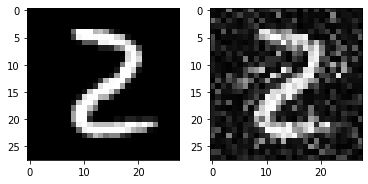

25  :  -0.31381014396929113 25
50  :  0.10707069230889808 25
75  :  -0.24593771094152617 25
100  :  0.11695782822150072 25
125  :  0.28414108288224926 25
150  :  0.27240189868556425 25
175  :  0.4425947159367154 25
200  :  0.4738641718518188 25
225  :  0.4800302464408078 25
250  :  0.4819446600556936 25
275  :  0.48162314900737546 25
300  :  0.48185511935701714 25
325  :  0.48428899933068864 25
350  :  0.4840914154578735 25
375  :  0.48466769210314126 25
400  :  0.4847822959708735 25
425  :  0.4852494603631907 25
450  :  0.48620887989377026 25
475  :  0.48673169941346495 25
500  :  0.48655758473637456 25
525  :  0.48654349026209504 25
550  :  0.4868870680927 25
575  :  0.4870225164172347 25
600  :  0.4873699558761775 25
625  :  0.4872986188528251 25
650  :  0.4874417133261994 25
675  :  0.4873997586310428 25
700  :  0.48791723212944965 25
725  :  0.48760146103837493 25
750  :  0.48798530950366303 25
775  :  0.48770142375926984 25
800  :  0.48781827007056544 25
825  :  0.488122626257374

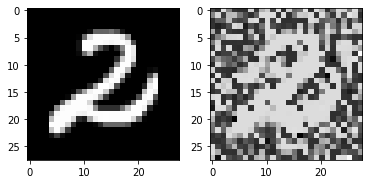

25  :  -0.26509178836416547 25
50  :  -0.020559447126416802 25
75  :  -0.08752802793842661 25
100  :  -0.030554991917373844 25
125  :  0.2726521563837392 25
150  :  0.08819447092673989 25
175  :  0.15194754133289246 25
200  :  0.17372718857785338 25
225  :  0.39190497741061475 25
250  :  0.41097578176394123 25
275  :  0.45863798667771344 25
300  :  0.40179558231233964 25
325  :  0.43676415114047595 25
350  :  0.4720106023319574 25
375  :  0.4313487185733168 25
400  :  0.4575405635695842 25
425  :  0.4493887015494119 25
450  :  0.47433761964548066 25
475  :  0.4644567909163539 25
500  :  0.46179552185813477 25
525  :  0.48003779396059393 25
550  :  0.4751873894420664 25
575  :  0.4714848530027205 25
600  :  0.4714848530027205 25
625  :  0.4806350418997982 25
650  :  0.4774097859136228 25
675  :  0.4862674861930005 25
700  :  0.47890250691962466 25
725  :  0.48106418366711506 25
750  :  0.48470769860896623 25
775  :  0.4841229511745096 25
800  :  0.4858046889631099 25
825  :  0.484602178

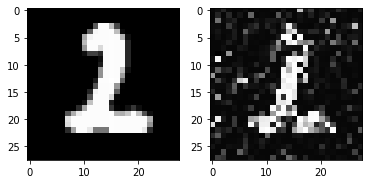

25  :  -0.4605532731571653 25
50  :  -0.39412249437773017 25
75  :  -0.3922950362109892 25
100  :  -0.2950133457607394 25
125  :  -0.10685655308798142 25
150  :  0.03460790967060769 25
175  :  0.3965001524318654 25
200  :  0.4728342760992989 25
225  :  0.48175762209046064 25
250  :  0.4828721136704588 25
275  :  0.4817252500114997 25
300  :  0.481156905611727 25
325  :  0.4830934401209563 25
350  :  0.4820819701266241 25
375  :  0.48405001702373346 25
400  :  0.48237644863440415 25
425  :  0.4843306961291858 25
450  :  0.4845763640729029 25
475  :  0.4855049692679981 25
500  :  0.48648492837623847 25
525  :  0.48588317622693983 25
550  :  0.4865927853285455 25
575  :  0.4866396132031023 25
600  :  0.48754640327822596 25
625  :  0.4877423949386373 25
650  :  0.487802867663787 25
675  :  0.4878959566466791 25
700  :  0.4882835779684702 25
725  :  0.48868317329225824 25
750  :  0.4888402667516076 25
775  :  0.48903150461680334 25
800  :  0.4890539991940986 25
825  :  0.4890783008978619 25

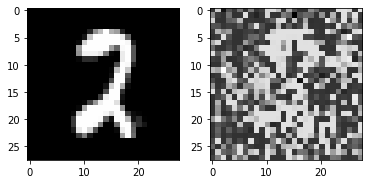

25  :  -0.4111240069947462 25
50  :  -0.26550107894060915 25
75  :  -0.16884080923968378 25
100  :  -0.017763569157528202 25
125  :  0.06321953970248151 25
150  :  0.10928993562693433 25
175  :  0.41664172379051395 25
200  :  0.48014987266865194 25
225  :  0.48280816327368364 25
250  :  0.48310749724082047 25
275  :  0.48296388192084805 25
300  :  0.4845717943048593 25
325  :  0.48460358135709974 25
350  :  0.48509503240695356 25
375  :  0.48616632064301984 25
400  :  0.48651540798459825 25
425  :  0.4862940957907575 25
450  :  0.48645755725582146 25
475  :  0.48720587923603575 25
500  :  0.48663763908318575 25
525  :  0.4874991323627971 25
550  :  0.488073625856032 25
575  :  0.48784847338175347 25
600  :  0.48761496405003213 25
625  :  0.48763584226586176 25
650  :  0.48807777121600066 25
675  :  0.4877907061581835 25
700  :  0.48801362006969895 25
725  :  0.4879615239659948 25
750  :  0.48829997863679114 25
775  :  0.48826672308033625 25
800  :  0.48844869162027904 25
825  :  0.4885

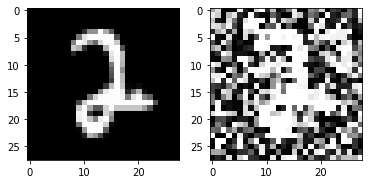

25  :  -0.4868491004037429 25
50  :  -0.4853432472972357 25
75  :  -0.4856561567769757 25
100  :  -0.48085399867208567 25
125  :  -0.461000725608309 25
150  :  -0.46239492830706497 25
175  :  -0.341120767056928 25
200  :  -0.2537571571112701 25
225  :  0.017008340203733912 25
250  :  0.15367169024171434 25
275  :  0.45212593674856844 25
300  :  0.48295653240092856 25
325  :  0.48535598123959023 25
350  :  0.4859117484898255 25
375  :  0.48605837745404556 25
400  :  0.4872778900806526 25
425  :  0.4873955027900133 25
450  :  0.48743474435755096 25
475  :  0.4875870045368719 25
500  :  0.48782924673356115 25
525  :  0.48795339541401844 25
550  :  0.48841973308839987 25
575  :  0.48849877776906303 25
600  :  0.4886542955506971 25
625  :  0.4888510972114225 25
650  :  0.4891476765874358 25
675  :  0.48920385088143975 25
700  :  0.4892740612082809 25
725  :  0.48929180773617176 25
750  :  0.4893771588452056 25
775  :  0.48942918641932265 25
800  :  0.48944112004527024 25
825  :  0.489622953

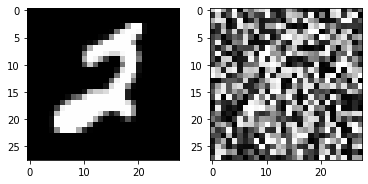

25  :  0.19052219102771517 25
50  :  0.39273520088245245 25
75  :  0.2170754242325858 25
100  :  0.3138014309570784 25
125  :  0.350769458645778 25
150  :  0.38369874324815484 25
175  :  0.4524995051581259 25
200  :  0.4452827159416761 25
225  :  0.43458983978925125 25
250  :  0.44491635054605577 25
275  :  0.44801809495884176 25
300  :  0.4617429411629496 25
325  :  0.4542780657099587 25
350  :  0.4639230814508017 25
375  :  0.4659064218822053 25
400  :  0.46756040363413376 25
425  :  0.47357758968629365 25
450  :  0.47530104402123236 25
475  :  0.47712976745857705 25
500  :  0.4792154115301169 25
525  :  0.48158311169958784 25
550  :  0.4814641949271492 25
575  :  0.482393256036442 25
600  :  0.48254484456756375 25
625  :  0.48326595365535685 25
650  :  0.4842552231958451 25
675  :  0.4856264285638003 25
700  :  0.4858421677809314 25
725  :  0.4870704985888167 25
750  :  0.48705043435594325 25
775  :  0.48705043435594325 25
800  :  0.4902039654041938 25
825  :  0.4904633622323981 25


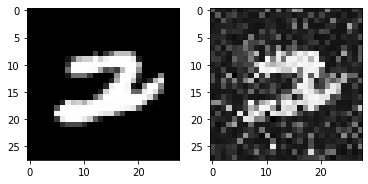

25  :  0.14739855183811218 25
50  :  0.4719880350840492 25
75  :  0.46440587912751913 25
100  :  0.4546099392198414 25
125  :  0.4732643689073897 25
150  :  0.4818993529115043 25
175  :  0.4852286868641067 25
200  :  0.484957235106731 25
225  :  0.4868953234447707 25
250  :  0.4879451783795057 25
275  :  0.4886288911745128 25
300  :  0.487825251750766 25
325  :  0.4879536620150513 25
350  :  0.4884994646223616 25
375  :  0.4884145112886084 25
400  :  0.4892728540863031 25
425  :  0.4893948101524633 25
450  :  0.48929209549956626 25
475  :  0.48917105189090654 25
500  :  0.4893888917956562 25
525  :  0.4898058129492444 25
550  :  0.4897972807405841 25
575  :  0.4900066989263436 25
600  :  0.49036589451674506 25
625  :  0.49019267865426136 25
650  :  0.49033006892017506 25
675  :  0.490423594862879 25
700  :  0.4905631369402247 25
725  :  0.4906664903449901 25
750  :  0.49068492026779403 25
775  :  0.49072101165042525 25
800  :  0.49076636842340426 25
825  :  0.49088255916359924 25
850  

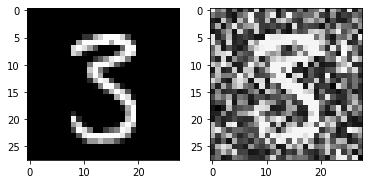

25  :  -0.42584377062258877 25
50  :  0.3089701373327125 25
75  :  -0.03135855760629952 25
100  :  0.33310668384238135 25
125  :  0.34613223506688745 25
150  :  0.441259337516915 25
175  :  0.4557846082506025 25
200  :  0.4824593254044773 25
225  :  0.4845042191268969 25
250  :  0.4847894365002159 25
275  :  0.48599663572060436 25
300  :  0.48615796150936047 25
325  :  0.48766795614986524 25
350  :  0.4861223236578336 25
375  :  0.4864486635535338 25
400  :  0.4874053298794398 25
425  :  0.48718259012220083 25
450  :  0.4876696229910289 25
475  :  0.48819716033315297 25
500  :  0.48820636574238085 25
525  :  0.4877669834665813 25
550  :  0.4879695302960754 25
575  :  0.48847438160559864 25
600  :  0.4878356232356801 25
625  :  0.48798064034596494 25
650  :  0.4881373364057616 25
675  :  0.4882020737889486 25
700  :  0.4881837375955051 25
725  :  0.48821896632192996 25
750  :  0.48828925289640485 25
775  :  0.4884079083270706 25
800  :  0.4885493061048701 25
825  :  0.48856838016923954 

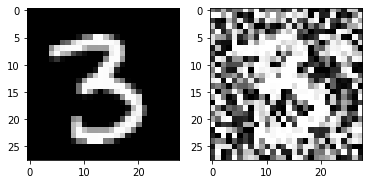

25  :  -0.17037632382744364 25
50  :  0.41486697359688646 25
75  :  -0.061854507812092153 25
100  :  0.12773904291574292 25
125  :  -0.2036767062707292 25
150  :  0.09748718672853672 25
175  :  0.3455931577690906 25
200  :  0.4159901214951037 25
225  :  0.41975566802569636 25
250  :  0.47382917857566287 25
275  :  0.4767414828943948 25
300  :  0.48069247474976196 25
325  :  0.48163194403617077 25
350  :  0.481537566187864 25
375  :  0.4819871013373516 25
400  :  0.48097056681207195 25
425  :  0.48111705970981206 25
450  :  0.48129701015307497 25
475  :  0.4824708538819834 25
500  :  0.4827385487818111 25
525  :  0.48309400329938 25
550  :  0.48432487983332795 25
575  :  0.4837620758420803 25
600  :  0.48456193935668773 25
625  :  0.4848066105391821 25
650  :  0.484948438126404 25
675  :  0.48557509066794163 25
700  :  0.48571989406704363 25
725  :  0.4860911235947384 25
750  :  0.4863216563556864 25
775  :  0.4864427445447482 25
800  :  0.48651790137793344 25
825  :  0.4867209073076671

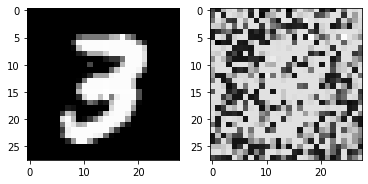

25  :  0.16712760479029662 25
50  :  0.44066366441730553 25
75  :  0.003081797383035023 25
100  :  0.32769731082542575 25
125  :  0.43531701438318265 25
150  :  0.4567032494269349 25
175  :  0.4762402093275638 25
200  :  0.4806901172304931 25
225  :  0.4829544780262121 25
250  :  0.48190818590781503 25
275  :  0.4808039920784529 25
300  :  0.4813399208458765 25
325  :  0.48250228296360337 25
350  :  0.48261970586072234 25
375  :  0.4838400863537676 25
400  :  0.4849404021712999 25
425  :  0.48595235329040276 25
450  :  0.48645074162201146 25
475  :  0.4867290045884751 25
500  :  0.4870445989645141 25
525  :  0.4870017029498836 25
550  :  0.4871846750067675 25
575  :  0.4872473388889166 25
600  :  0.4874993948520246 25
625  :  0.4875039816606269 25
650  :  0.487672732822358 25
675  :  0.48795369187677234 25
700  :  0.4878578644680448 25
725  :  0.4879502790250962 25
750  :  0.4880170405846368 25
775  :  0.48804303296055407 25
800  :  0.4882277527871086 25
825  :  0.4883622276522511 25
8

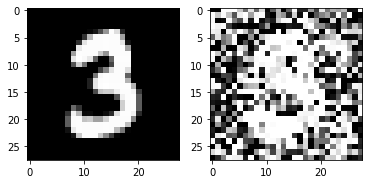

25  :  -0.2211570786626146 25
50  :  0.37363025657207244 25
75  :  0.20146853534009637 25
100  :  0.33783589194435654 25
125  :  0.40053574144748355 25
150  :  0.44042077734054935 25
175  :  0.47533852640499397 25
200  :  0.4827421873831836 25
225  :  0.48532415768210635 25
250  :  0.48610947213465955 25
275  :  0.48408964023548523 25
300  :  0.4849276143133572 25
325  :  0.48666982141754594 25
350  :  0.48904593759936077 25
375  :  0.4884067936111609 25
400  :  0.48935242419794467 25
425  :  0.489225813627574 25
450  :  0.48918144248468876 25
475  :  0.4895608557472077 25
500  :  0.4899766709362691 25
525  :  0.48978389145125417 25
550  :  0.48964741046743854 25
575  :  0.48984692692172194 25
600  :  0.49004808655189586 25
625  :  0.4901537931511754 25
650  :  0.49021504021429113 25
675  :  0.4903408825422746 25
700  :  0.4905350172346582 25
725  :  0.490518899398573 25
750  :  0.4905492794692512 25
775  :  0.4905492794692512 25
800  :  0.49062390587214855 25
825  :  0.490757958847353

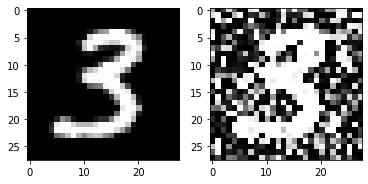

25  :  -0.44375894800206706 25
50  :  0.3054056645947906 25
75  :  -0.016623233282365653 25
100  :  0.2795288321082708 25
125  :  0.3897808009022376 25
150  :  0.4387952338273159 25
175  :  0.4705685595780547 25
200  :  0.47926266526938055 25
225  :  0.483476778280367 25
250  :  0.4831313202085137 25
275  :  0.48450820542040574 25
300  :  0.48456258060013524 25
325  :  0.4848159337179184 25
350  :  0.4860388506656229 25
375  :  0.4861107343413786 25
400  :  0.48626614211825203 25
425  :  0.4869542675934865 25
450  :  0.4865246561648021 25
475  :  0.4877678041613497 25
500  :  0.4872044684122879 25
525  :  0.48761673425592433 25
550  :  0.48814013203965806 25
575  :  0.4879380479346151 25
600  :  0.48819119080621676 25
625  :  0.48802333284787447 25
650  :  0.48846490132001746 25
675  :  0.4884685274634082 25
700  :  0.4887807137984954 25
725  :  0.48920822281470294 25
750  :  0.4894123177852239 25
775  :  0.4894291626177286 25
800  :  0.48950000396812654 25
825  :  0.489557630155988 25

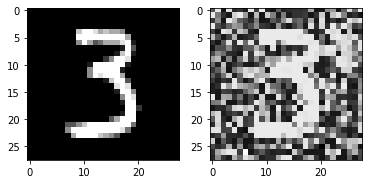

25  :  -0.4778434567447411 25
50  :  0.23732139116776077 25
75  :  -0.4233582285673175 25
100  :  -0.43310816617050985 25
125  :  -0.42236128662697314 25
150  :  -0.004595122356347743 25
175  :  -0.1692439891707794 25
200  :  -0.2953329922488778 25
225  :  0.2727601676030365 25
250  :  0.4480566524686855 25
275  :  0.47354471830858036 25
300  :  0.48460064269702524 25
325  :  0.48306506801709037 25
350  :  0.48222181331088976 25
375  :  0.48332192239583327 25
400  :  0.48304579935428094 25
425  :  0.4829902446715151 25
450  :  0.48395240377723103 25
475  :  0.48541275282103935 25
500  :  0.4853172633288288 25
525  :  0.4852981780404827 25
550  :  0.4859601167609271 25
575  :  0.48626786396841964 25
600  :  0.48666974021652515 25
625  :  0.4875418262660095 25
650  :  0.48777998019418756 25
675  :  0.4881521087613762 25
700  :  0.48824291498939604 25
725  :  0.4884064906081744 25
750  :  0.48864981534217694 25
775  :  0.4889392532122266 25
800  :  0.48895908917829745 25
825  :  0.4890987

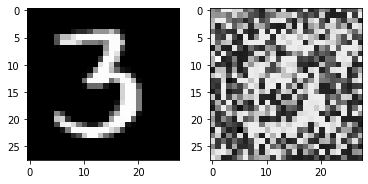

25  :  -0.4888178099643778 25
50  :  -0.27109819596951756 25
75  :  -0.3287453030721146 25
100  :  -0.20649407262070268 25
125  :  -0.18612624149730847 25
150  :  -0.11428227752245257 25
175  :  0.24377688691735594 25
200  :  0.39709046015876537 25
225  :  0.4548599071315294 25
250  :  0.48113877791341914 25
275  :  0.4834387108086011 25
300  :  0.48384759454151866 25
325  :  0.4818106826433876 25
350  :  0.48261324532836686 25
375  :  0.48425148849612837 25
400  :  0.4842198135153379 25
425  :  0.48408100815956134 25
450  :  0.4853119273018441 25
475  :  0.485364023860672 25
500  :  0.4859049674882339 25
525  :  0.4862954735303475 25
550  :  0.486156491457139 25
575  :  0.48695489514289486 25
600  :  0.4875267233818302 25
625  :  0.4875352652145583 25
650  :  0.4879759684076286 25
675  :  0.4880608333208599 25
700  :  0.48786534113023083 25
725  :  0.488550468579305 25
750  :  0.4883678532543402 25
775  :  0.48849297724504126 25
800  :  0.48849297724504126 25
825  :  0.488511421097958

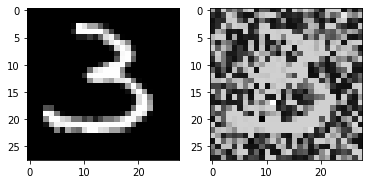

25  :  0.4626331350971811 25
50  :  0.4885998010154201 25
75  :  0.487522095431476 25
100  :  0.4878563804479287 25
125  :  0.4855247434643042 25
150  :  0.48820577730056336 25
175  :  0.48791717361592013 25
200  :  0.48828455684585753 25
225  :  0.48718791393509614 25
250  :  0.48605477126781504 25
275  :  0.48549505662105835 25
300  :  0.4861427184945446 25
325  :  0.4874850528821966 25
350  :  0.4880261904171851 25
375  :  0.48871373504456783 25
400  :  0.48894809948596113 25
425  :  0.4892460371322636 25
450  :  0.4890494221433667 25
475  :  0.4892967745003996 25
500  :  0.4901690042534411 25
525  :  0.49031707976828204 25
550  :  0.49045245451465314 25
575  :  0.49056507743193356 25
600  :  0.49097710600355776 25
625  :  0.49104154281859097 25
650  :  0.4909607686213196 25
675  :  0.49101506157570785 25
700  :  0.49109201822984505 25
725  :  0.49113372704275565 25
750  :  0.4911793358946753 25
775  :  0.4912364271945995 25
800  :  0.49128936415430235 25
825  :  0.49132732431065657

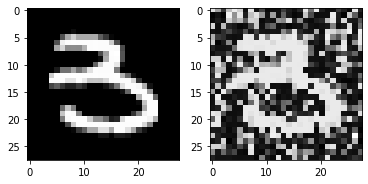

25  :  -0.23906548232834654 25
50  :  -0.23235930432279683 25
75  :  -0.23079133210401703 25
100  :  -0.17055176865294072 25
125  :  -0.13492809793498342 25
150  :  -0.05674728660639383 25
175  :  -0.016376184515702254 25
200  :  0.20546943047270225 25
225  :  0.27075465750753636 25
250  :  0.401905684790972 25
275  :  0.4410327225870551 25
300  :  0.4505618753064081 25
325  :  0.46297707564605634 25
350  :  0.46803251480434405 25
375  :  0.4670859468698583 25
400  :  0.4753259021995763 25
425  :  0.47783326909404544 25
450  :  0.48272291973902043 25
475  :  0.48739811618688605 25
500  :  0.48792728481008674 25
525  :  0.4877806687238752 25
550  :  0.49023697001540756 25
575  :  0.490984565889497 25
600  :  0.4912733969923598 25
625  :  0.4924707136557515 25
650  :  0.49267212163891516 25
675  :  0.4926804204686581 25
700  :  0.49276275135836084 25
725  :  0.49304220741380456 25
750  :  0.4931700240851809 25
775  :  0.49331327532073105 25
800  :  0.4936796152463125 25
825  :  0.4937470

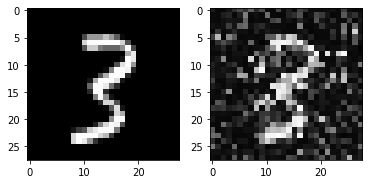

25  :  -0.4808273997457364 25
50  :  0.00659019490281682 25
75  :  -0.3651479886270847 25
100  :  -0.45025078718398914 25
125  :  -0.21271551818329867 25
150  :  -0.06122152697257233 25
175  :  0.1733598406315626 25
200  :  0.25871046989553725 25
225  :  0.43295603134931354 25
250  :  0.46712287834521604 25
275  :  0.47492571033593556 25
300  :  0.48047470219329863 25
325  :  0.48029187591675904 25
350  :  0.48132628843691655 25
375  :  0.481232429950604 25
400  :  0.4821078678790812 25
425  :  0.48361807009382973 25
450  :  0.48448698881643704 25
475  :  0.48594396140088447 25
500  :  0.48589981474359806 25
525  :  0.48626432036706996 25
550  :  0.4863889975474399 25
575  :  0.48615346986967795 25
600  :  0.4866687585532543 25
625  :  0.4865335901978276 25
650  :  0.486771373737528 25
675  :  0.48678369114105924 25
700  :  0.48655958815246525 25
725  :  0.48653477558396463 25
750  :  0.48685257264810977 25
775  :  0.48694723439663173 25
800  :  0.48699500394340395 25
825  :  0.4870230

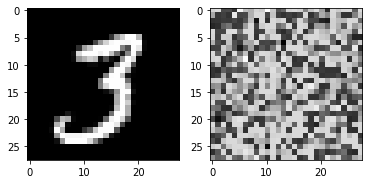

25  :  0.031190904109132875 25
50  :  0.4783211301983859 25
75  :  0.41878814250134005 25
100  :  0.465195279582552 25
125  :  0.4766301037395872 25
150  :  0.48461709442115025 25
175  :  0.4857190791071401 25
200  :  0.486270510481296 25
225  :  0.4864333288303322 25
250  :  0.4877898827715453 25
275  :  0.48758551881459156 25
300  :  0.4881574624917533 25
325  :  0.4878754815137489 25
350  :  0.48840127440280806 25
375  :  0.48865526276662713 25
400  :  0.489139856084862 25
425  :  0.4889086809372737 25
450  :  0.4890425150048661 25
475  :  0.48903513737461174 25
500  :  0.4893469488578223 25
525  :  0.48927730474580705 25
550  :  0.4893929195567424 25
575  :  0.48973302171542893 25
600  :  0.4901354878578739 25
625  :  0.4906315915063011 25
650  :  0.49087629927946574 25
675  :  0.4908305665013857 25
700  :  0.4909012653772076 25
725  :  0.49092729178768707 25
750  :  0.49092729178768707 25
775  :  0.49095070213939895 25
800  :  0.49101475751246615 25
825  :  0.491011831507401 25
85

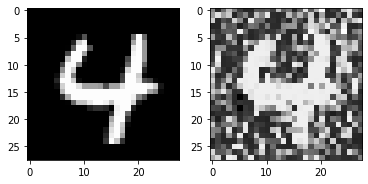

25  :  0.2728348571678465 25
50  :  0.47585043904427893 25
75  :  0.40587622243252747 25
100  :  0.42278873123467703 25
125  :  0.42576374944232387 25
150  :  0.4681714379143782 25
175  :  0.4769747852336038 25
200  :  0.48039484011911404 25
225  :  0.48290208072599994 25
250  :  0.4823174796668027 25
275  :  0.48220292657197084 25
300  :  0.4824505714457451 25
325  :  0.4826568401255497 25
350  :  0.48287909353068703 25
375  :  0.4835246473609276 25
400  :  0.48394106018031957 25
425  :  0.48462717579079323 25
450  :  0.4854057095190567 25
475  :  0.48669289652830916 25
500  :  0.48669915107800554 25
525  :  0.48712479367866135 25
550  :  0.4871901956902926 25
575  :  0.4871708637137264 25
600  :  0.48722366577319737 25
625  :  0.4875330405044569 25
650  :  0.4876867796380419 25
675  :  0.4877090344122365 25
700  :  0.4875778743265107 25
725  :  0.4880288852647666 25
750  :  0.4882114990510085 25
775  :  0.48817217506565713 25
800  :  0.4883510415669654 25
825  :  0.48871257836760107 

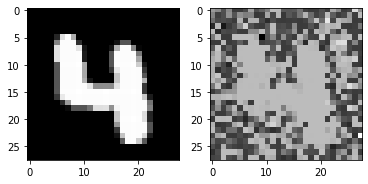

25  :  -0.23073157372798017 25
50  :  0.26867416292072555 25
75  :  -0.03354583470257584 25
100  :  0.14102378463836546 25
125  :  0.440321436647814 25
150  :  0.48013316946935164 25
175  :  0.48010356675245913 25
200  :  0.48394509689798076 25
225  :  0.4833030481130914 25
250  :  0.48308019480601166 25
275  :  0.48347781233175974 25
300  :  0.48355203328339785 25
325  :  0.48525648989312675 25
350  :  0.48623650205064656 25
375  :  0.48662535393659867 25
400  :  0.4871141545017587 25
425  :  0.4872969290956113 25
450  :  0.4879192079802462 25
475  :  0.48839573059253805 25
500  :  0.48801503125307333 25
525  :  0.48842053531953894 25
550  :  0.4885796352976147 25
575  :  0.48874834689430513 25
600  :  0.48903064329104734 25
625  :  0.48914791938028107 25
650  :  0.4893961519856066 25
675  :  0.4895804212923397 25
700  :  0.48989320588309127 25
725  :  0.48998864667709696 25
750  :  0.49011916050212584 25
775  :  0.4903606950113804 25
800  :  0.49024678910860675 25
825  :  0.490246789

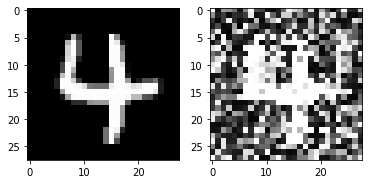

25  :  -0.28371099643871006 25
50  :  0.47998174947658523 25
75  :  0.2943513946933278 25
100  :  0.45632537800168765 25
125  :  0.47927455558689597 25
150  :  0.4887318342260811 25
175  :  0.4892863662271059 25
200  :  0.489661492841926 25
225  :  0.48936385045241565 25
250  :  0.489671470048154 25
275  :  0.4903661457798543 25
300  :  0.4921117432057356 25
325  :  0.49205200990702097 25
350  :  0.4920039695395228 25
375  :  0.4925039465035453 25
400  :  0.4925920823668874 25
425  :  0.4925671494225942 25
450  :  0.49284719276671374 25
475  :  0.4929808087668473 25
500  :  0.4930223781823129 25
525  :  0.4930223781823129 25
550  :  0.4930223781823129 25
575  :  0.4930223781823129 25
600  :  0.4931256775710338 25
625  :  0.4931256775710338 25
650  :  0.4931256775710338 25
675  :  0.4933570216719635 25
700  :  0.4933576961411283 25
725  :  0.4933576961411283 25
750  :  0.4933576961411283 25
775  :  0.4933755318365409 25
800  :  0.49337995366777954 25
825  :  0.493482179701388 25
850  : 

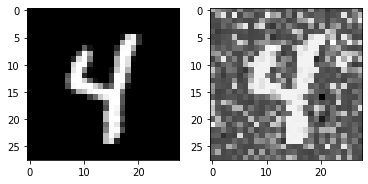

25  :  -0.30979542609176997 25
50  :  0.34281524805282504 25
75  :  0.2951971587957791 25
100  :  0.43076132536560635 25
125  :  0.4698810579005499 25
150  :  0.4707608606088623 25
175  :  0.4844081153261002 25
200  :  0.4859904047542517 25
225  :  0.4859399698363139 25
250  :  0.4865841420116868 25
275  :  0.48864789572893735 25
300  :  0.48788220571920415 25
325  :  0.489776884076674 25
350  :  0.4882297637726941 25
375  :  0.4897689682246486 25
400  :  0.4904679014504029 25
425  :  0.48972071991266997 25
450  :  0.489892021934933 25
475  :  0.4901761151462274 25
500  :  0.490674920745807 25
525  :  0.4904990824105487 25
550  :  0.4911284005500578 25
575  :  0.49095429424327186 25
600  :  0.49095429424327186 25
625  :  0.49114958268718506 25
650  :  0.49114805438621956 25
675  :  0.49118123194508906 25
700  :  0.4914401406948368 25
725  :  0.4914418451900001 25
750  :  0.4914418451900001 25
775  :  0.4914418451900001 25
800  :  0.49146458434088536 25
825  :  0.49150093963951225 25
85

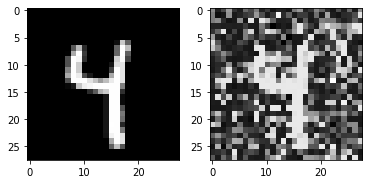

25  :  -0.32970574523751184 25
50  :  0.22228869490302228 25
75  :  0.10381512938924957 25
100  :  0.3065023851577788 25
125  :  0.39567875425414484 25
150  :  0.46145628246081916 25
175  :  0.46113011424483913 25
200  :  0.46717791088313587 25
225  :  0.4672793096926876 25
250  :  0.48355711528844636 25
275  :  0.48331249928150194 25
300  :  0.48360345427931767 25
325  :  0.4834492128054589 25
350  :  0.48400021505455854 25
375  :  0.4870072351544973 25
400  :  0.486439613786081 25
425  :  0.4874906585013418 25
450  :  0.48808525094578475 25
475  :  0.4884693791843661 25
500  :  0.4890575256099657 25
525  :  0.488907472357647 25
550  :  0.489413692369105 25
575  :  0.48946181391861576 25
600  :  0.489554102974312 25
625  :  0.48990189186625815 25
650  :  0.48990189186625815 25
675  :  0.49008332106225677 25
700  :  0.4902558512180686 25
725  :  0.49023790201008843 25
750  :  0.4902246200174063 25
775  :  0.49029613825380375 25
800  :  0.4903604241550268 25
825  :  0.4904586187893641 2

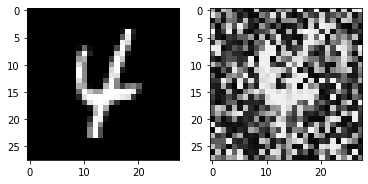

25  :  -0.35321357420346433 25
50  :  0.3634679310332869 25
75  :  -0.04123483869279569 25
100  :  -0.08779900737286044 25
125  :  0.25101139825642466 25
150  :  0.42105806916663613 25
175  :  0.4675214079275831 25
200  :  0.4814923457744068 25
225  :  0.4837133484272184 25
250  :  0.4838945830307292 25
275  :  0.48439523012634766 25
300  :  0.48439282105266035 25
325  :  0.48527843417030175 25
350  :  0.48713157053662703 25
375  :  0.4881754672633341 25
400  :  0.48871444503549033 25
425  :  0.48899215155635856 25
450  :  0.4885651360266356 25
475  :  0.48904613078946846 25
500  :  0.4897284429571625 25
525  :  0.48930621846493344 25
550  :  0.48940289820575755 25
575  :  0.48963723474926546 25
600  :  0.489878141905204 25
625  :  0.48990723243318274 25
650  :  0.48991604456362214 25
675  :  0.49018072466715984 25
700  :  0.49024486265525424 25
725  :  0.49026032831044414 25
750  :  0.4903436822397866 25
775  :  0.4904221810532009 25
800  :  0.49053193148118 25
825  :  0.4906064870164

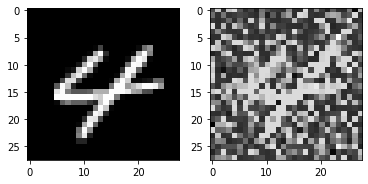

25  :  -0.4743666217251334 25
50  :  0.4451216281300356 25
75  :  0.14281668185523652 25
100  :  0.24729867195518576 25
125  :  0.4664267150097202 25
150  :  0.46658946700004406 25
175  :  0.48867815934912595 25
200  :  0.4892348682322972 25
225  :  0.49046438764469374 25
250  :  0.4902605000938638 25
275  :  0.49135546753653836 25
300  :  0.4910136385899832 25
325  :  0.491271731808349 25
350  :  0.49150206010326986 25
375  :  0.4914599087795544 25
400  :  0.4918327747593602 25
425  :  0.49180724847618423 25
450  :  0.49180724847618423 25
475  :  0.49180724847618423 25
500  :  0.491875786019755 25
525  :  0.49204572467135155 25
550  :  0.49225047695883767 25
575  :  0.4923410025826821 25
600  :  0.49249088769765315 25
625  :  0.49251215636479184 25
650  :  0.4925743106030045 25
675  :  0.49262461881165437 25
700  :  0.4926413219312955 25
725  :  0.49276049146983586 25
750  :  0.4927783764993162 25
775  :  0.49277640065147094 25
800  :  0.4928813165968459 25
825  :  0.4929137083900483 

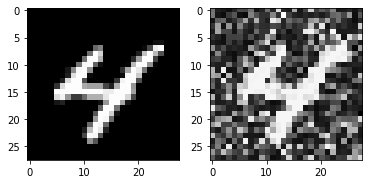

25  :  -0.11737186914871797 25
50  :  0.3844677875294483 25
75  :  0.18240254166719583 25
100  :  0.44623070628493355 25
125  :  0.47786046559207274 25
150  :  0.4906343519342764 25
175  :  0.49104515382750735 25
200  :  0.48849401019789107 25
225  :  0.4884931738870952 25
250  :  0.48760141239930893 25
275  :  0.48935580001649104 25
300  :  0.4900362001235518 25
325  :  0.4900473417269989 25
350  :  0.4900473417269989 25
375  :  0.49096459340941845 25
400  :  0.4915426528719923 25
425  :  0.49195319119974057 25
450  :  0.49232750241009304 25
475  :  0.49232750241009304 25
500  :  0.49260326505035007 25
525  :  0.49260326505035007 25
550  :  0.4928163951769633 25
575  :  0.4929222245873724 25
600  :  0.4930133445360546 25
625  :  0.4930510299598568 25
650  :  0.4931637769999525 25
675  :  0.4931637769999525 25
700  :  0.4933697667075931 25
725  :  0.49335867840010567 25
750  :  0.49335867840010567 25
775  :  0.49335867840010567 25
800  :  0.49335867840010567 25
825  :  0.49337997598718

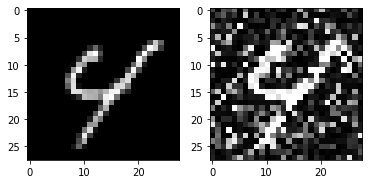

25  :  -0.3933470812303044 25
50  :  0.16549877092227022 25
75  :  -0.16479729898725806 25
100  :  0.2323122999858978 25
125  :  0.43908988048192826 25
150  :  0.46814989526729717 25
175  :  0.48094537692744393 25
200  :  0.48610742603003404 25
225  :  0.48732784254899675 25
250  :  0.4857263202572252 25
275  :  0.4871366005303794 25
300  :  0.48822270186113403 25
325  :  0.48829611874163614 25
350  :  0.4891517996598539 25
375  :  0.4889930829482946 25
400  :  0.4901999390530775 25
425  :  0.4899317882985402 25
450  :  0.49045021132902344 25
475  :  0.49103146124446445 25
500  :  0.4912075750231222 25
525  :  0.4910426686245677 25
550  :  0.4910538116508744 25
575  :  0.4911799567250035 25
600  :  0.49144748233087593 25
625  :  0.4914460279456782 25
650  :  0.49163776994050185 25
675  :  0.4916156146664371 25
700  :  0.4916126061725109 25
725  :  0.49170346752159916 25
750  :  0.49181984316954236 25
775  :  0.4919054264018783 25
800  :  0.49197379465532853 25
825  :  0.491972990138459

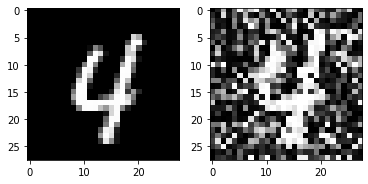

25  :  -0.26283067712004665 25
50  :  0.33145409418901656 25
75  :  0.19158447288085767 25
100  :  0.3637135966791284 25
125  :  0.445870639964239 25
150  :  0.46484538195422004 25
175  :  0.48273148350724965 25
200  :  0.4856395655034728 25
225  :  0.48558298919282006 25
250  :  0.4849737365098089 25
275  :  0.48638630553423545 25
300  :  0.4874459464477052 25
325  :  0.4873180901957076 25
350  :  0.4881785422959615 25
375  :  0.48772095901984164 25
400  :  0.4885049935352703 25
425  :  0.4883071777139171 25
450  :  0.4883831214562885 25
475  :  0.4892373882690291 25
500  :  0.4891091559106733 25
525  :  0.4890287822347508 25
550  :  0.4894316078073404 25
575  :  0.4895464773121686 25
600  :  0.48969298738270056 25
625  :  0.4898936597682469 25
650  :  0.48990999018616666 25
675  :  0.4900116834687631 25
700  :  0.49003632064903824 25
725  :  0.49003632064903824 25
750  :  0.49003632064903824 25
775  :  0.4902559167627738 25
800  :  0.4902594391031066 25
825  :  0.4902594391031066 25


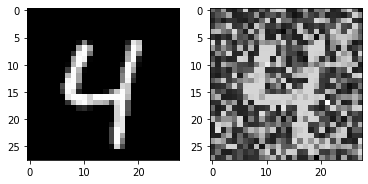

25  :  0.3007689509334868 25
50  :  0.47459486269806267 25
75  :  0.42067198908310116 25
100  :  0.4415697618280799 25
125  :  0.4574084682295826 25
150  :  0.46043549541252354 25
175  :  0.47486305180708616 25
200  :  0.4844894677863059 25
225  :  0.48428751299082895 25
250  :  0.4851098444970934 25
275  :  0.48530339645976456 25
300  :  0.48549195300735254 25
325  :  0.48719738745497254 25
350  :  0.4876686155406726 25
375  :  0.4870363452346591 25
400  :  0.48731525073382476 25
425  :  0.4876817086322517 25
450  :  0.48764247632318514 25
475  :  0.48765232707409534 25
500  :  0.4879032575364169 25
525  :  0.4881195378567287 25
550  :  0.48816005157888587 25
575  :  0.48834132059743873 25
600  :  0.48848964654053967 25
625  :  0.48881672264964393 25
650  :  0.4889193569715299 25
675  :  0.4889193569715299 25
700  :  0.4889459307585748 25
725  :  0.489080223370904 25
750  :  0.48921726417608974 25
775  :  0.48919359777173627 25
800  :  0.48925815429945985 25
825  :  0.4894436048632615

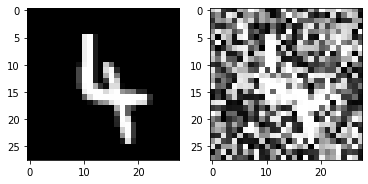

25  :  -0.13777089967562037 25
50  :  0.16073894501403316 25
75  :  0.1126585754165413 25
100  :  0.31713928913461525 25
125  :  0.4664060584009801 25
150  :  0.4556025050618115 25
175  :  0.48514153975370694 25
200  :  0.4888603930153144 25
225  :  0.4893854862210105 25
250  :  0.4886796560507764 25
275  :  0.4891094141121744 25
300  :  0.4895731474332361 25
325  :  0.4894669156667483 25
350  :  0.48929286505028136 25
375  :  0.4896066803842542 25
400  :  0.4899238784335126 25
425  :  0.49010631118773096 25
450  :  0.49009631780500856 25
475  :  0.4905327225780549 25
500  :  0.4907567327064629 25
525  :  0.4906480903119308 25
550  :  0.490643215906607 25
575  :  0.49079858224662576 25
600  :  0.49092597011606837 25
625  :  0.49104981795406527 25
650  :  0.4912892416244269 25
675  :  0.4913435887842507 25
700  :  0.49127389158231377 25
725  :  0.4914653214272225 25
750  :  0.4914675098867433 25
775  :  0.49154534909600833 25
800  :  0.49154534909600833 25
825  :  0.4916225563591349 25


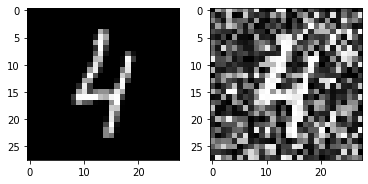

25  :  -0.42709909956400555 25
50  :  -0.41822528227263883 25
75  :  -0.39869507241638 25
100  :  -0.38570700865836727 25
125  :  -0.3513552737642221 25
150  :  -0.3006259232839718 25
175  :  -0.1942167727500021 25
200  :  -0.01769051912921591 25
225  :  0.08754976344958564 25
250  :  0.16536591917514415 25
275  :  0.1456479385887409 25
300  :  0.23658503951867066 25
325  :  0.31570197652940646 25
350  :  0.3634314591949352 25
375  :  0.31881125346697 25
400  :  0.35375923401249953 25
425  :  0.40247250451178995 25
450  :  0.4060841928348535 25
475  :  0.4352906877929779 25
500  :  0.44072293938751556 25
525  :  0.44072293938751556 25
550  :  0.4517458117087269 25
575  :  0.45627735731388314 25
600  :  0.45609932686492105 25
625  :  0.4642054135423677 25
650  :  0.4665434326526974 25
675  :  0.47089325231094903 25
700  :  0.47167601687688354 25
725  :  0.47201648303750093 25
750  :  0.4745915280348644 25
775  :  0.4764582711685875 25
800  :  0.4783122241938014 25
825  :  0.479797053435

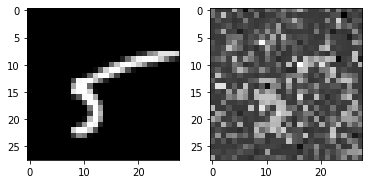

25  :  -0.3743545064539883 25
50  :  -0.3620406312244408 25
75  :  -0.37022763532718395 25
100  :  -0.3087196673969008 25
125  :  -0.25113907776017785 25
150  :  -0.21195464541216766 25
175  :  -0.06968730083615507 25
200  :  0.1946023075357188 25
225  :  0.18738872182865587 25
250  :  0.1655673825026268 25
275  :  0.14959993384731338 25
300  :  0.10961211132822679 25
325  :  0.2766440073666107 25
350  :  0.2119782416336934 25
375  :  0.2791082408797895 25
400  :  0.2791082408797895 25
425  :  0.3278616754379624 25
450  :  0.36434846302409823 25
475  :  0.41728147908517577 25
500  :  0.4131992588644512 25
525  :  0.4238094126148952 25
550  :  0.4289620446029683 25
575  :  0.43701930372521114 25
600  :  0.4576108615810144 25
625  :  0.47147074558289764 25
650  :  0.4697109230515722 25
675  :  0.4695540554280015 25
700  :  0.47028786668018646 25
725  :  0.47996295788988685 25
750  :  0.47996295788988685 25
775  :  0.48230966553210025 25
800  :  0.4827603773462253 25
825  :  0.48316063892

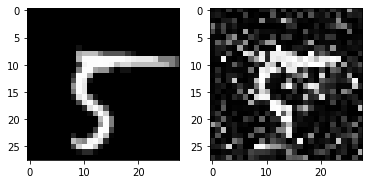

25  :  -0.4579918262123956 25
50  :  -0.4579918262123956 25
75  :  -0.4519107296304865 25
100  :  -0.4104889640617302 25
125  :  -0.35220040374270556 25
150  :  -0.33902493622758934 25
175  :  -0.22776949935091031 25
200  :  -0.13105390913418 25
225  :  -0.0592804046585087 25
250  :  -0.06229675356007337 25
275  :  -0.03724743652830841 25
300  :  0.056854094978405004 25
325  :  0.17459289529781383 25
350  :  0.1774261637728769 25
375  :  0.23772554422661918 25
400  :  0.24666981159109067 25
425  :  0.2927104367650582 25
450  :  0.2927104367650582 25
475  :  0.3095433104477328 25
500  :  0.3126111022987763 25
525  :  0.34703989058162305 25
550  :  0.3538577153289182 25
575  :  0.368176848424167 25
600  :  0.37270532902250836 25
625  :  0.3865401041370312 25
650  :  0.39603783759991695 25
675  :  0.41355065645224676 25
700  :  0.4125689231945142 25
725  :  0.426570326215724 25
750  :  0.4272658774394908 25
775  :  0.43684979430299553 25
800  :  0.44056330029899077 25
825  :  0.4536314374

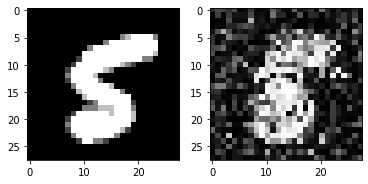

25  :  -0.4922889680394185 25
50  :  -0.4901576794204615 25
75  :  -0.48739685647105147 25
100  :  -0.48414682969460376 25
125  :  -0.4617092143523113 25
150  :  -0.40606232981043366 25
175  :  -0.3721445157167171 25
200  :  -0.16408221713698415 25
225  :  -0.05825039377688764 25
250  :  0.06770650803773906 25
275  :  0.10524799225623693 25
300  :  0.0959351737311565 25
325  :  0.15668799424867075 25
350  :  0.22180984924110497 25
375  :  0.22208294811363616 25
400  :  0.281516118207611 25
425  :  0.28654551490569563 25
450  :  0.2914146519017587 25
475  :  0.2957177129540196 25
500  :  0.33291808203785206 25
525  :  0.33654540680044537 25
550  :  0.33654540680044537 25
575  :  0.3452606579015191 25
600  :  0.3777549808147364 25
625  :  0.3866716141914942 25
650  :  0.39555113400414244 25
675  :  0.4297987607417496 25
700  :  0.428976963066072 25
725  :  0.4309001868116044 25
750  :  0.4430552876601927 25
775  :  0.44346479567946084 25
800  :  0.4479860217362605 25
825  :  0.4609133538

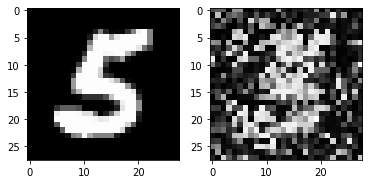

25  :  -0.4890689997870861 25
50  :  -0.4883580587174123 25
75  :  -0.48481167847579704 25
100  :  -0.48095378016532453 25
125  :  -0.4731457560536646 25
150  :  -0.4561299107449603 25
175  :  -0.4216844262793611 25
200  :  -0.4002376011331056 25
225  :  -0.37621478282033516 25
250  :  -0.3370202302163914 25
275  :  -0.3283550739358451 25
300  :  -0.23978614732162853 25
325  :  -0.20129765515482248 25
350  :  -0.20129765515482248 25
375  :  -0.12648391529498612 25
400  :  -0.11814198740752647 25
425  :  -0.05242608936883642 25
450  :  -0.007076175100867692 25
475  :  0.010842914964402116 25
500  :  0.0982963447448722 25
525  :  0.1012546192677626 25
550  :  0.13727649599599256 25
575  :  0.15141116829077977 25
600  :  0.21517494158085904 25
625  :  0.2286791700526958 25
650  :  0.252293359555521 25
675  :  0.26751018920342906 25
700  :  0.2748381715811699 25
725  :  0.2802838400219253 25
750  :  0.2895597232385246 25
775  :  0.3112070730949527 25
800  :  0.33309354127202184 25
825  :  

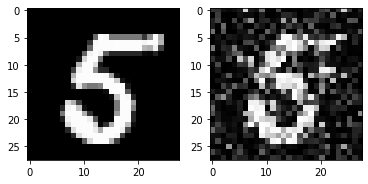

25  :  -0.3525654730348295 25
50  :  -0.32409528985714287 25
75  :  -0.308633105699278 25
100  :  -0.291879009601136 25
125  :  -0.1527198423759678 25
150  :  0.021707064873243694 25
175  :  0.21559019229914064 25
200  :  0.2765534739517448 25
225  :  0.2851902171377786 25
250  :  0.347909460434919 25
275  :  0.40832302692122713 25
300  :  0.4062537637583655 25
325  :  0.4128673990721609 25
350  :  0.4326930625033569 25
375  :  0.4358248400563517 25
400  :  0.4398353819971121 25
425  :  0.4589273964810813 25
450  :  0.47694687523569446 25
475  :  0.4809191730791859 25
500  :  0.48301056030601186 25
525  :  0.48404384535647343 25
550  :  0.4872438046862105 25
575  :  0.48805084831535434 25
600  :  0.4888264626275371 25
625  :  0.488934585293914 25
650  :  0.488934585293914 25
675  :  0.4893697080499284 25
700  :  0.4897868873776172 25
725  :  0.49090613122246174 25
750  :  0.49135338658372507 25
775  :  0.49132307418537136 25
800  :  0.49193145211961853 25
825  :  0.49201877118152987 25

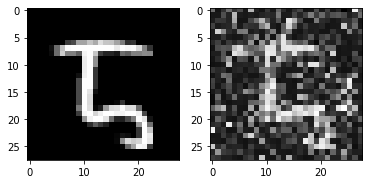

25  :  0.4645433328226859 25
50  :  0.4645433328226859 25
75  :  0.4666963257245188 25
100  :  0.47069475669614436 25
125  :  0.47546900665361286 25
150  :  0.4794044115177291 25
175  :  0.48365103841198653 25
200  :  0.48490400438813236 25
225  :  0.4897640340740732 25
250  :  0.4915267149569815 25
275  :  0.4922474443827235 25
300  :  0.4925677957310802 25
325  :  0.4931064617180513 25
350  :  0.49446351417617945 25
375  :  0.49453657883223373 25
400  :  0.49453657883223373 25
425  :  0.49487893729916943 25
450  :  0.495536703421558 25
475  :  0.4956805746648536 25
500  :  0.49580431132147956 25
525  :  0.4958940240235953 25
550  :  0.4959091214373994 25
575  :  0.49597600658506874 25
600  :  0.49599472152283924 25
625  :  0.4960163790230521 25
650  :  0.4960782898576432 25
675  :  0.49612552848325914 25
700  :  0.4961934423763111 25
725  :  0.4961934423763111 25
750  :  0.4962613307205144 25
775  :  0.49626428385096794 25
800  :  0.49630393757869556 25
Time:  73.80868601799011  seco

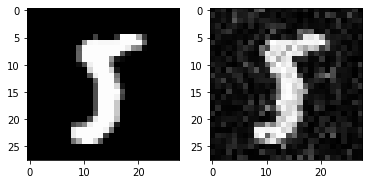

25  :  0.26543401903123287 25
50  :  0.2684056439489595 25
75  :  0.3157308136176762 25
100  :  0.33800769789320867 25
125  :  0.360378907880137 25
150  :  0.4053220860127468 25
175  :  0.40996380519983683 25
200  :  0.4276065831547299 25
225  :  0.4477541120377079 25
250  :  0.4626297021016725 25
275  :  0.48097518324323524 25
300  :  0.48483775548486535 25
325  :  0.486615961534452 25
350  :  0.4883275518589177 25
375  :  0.49161022493334094 25
400  :  0.49300457994787117 25
425  :  0.49476949944972953 25
450  :  0.49476949944972953 25
475  :  0.49495324681365194 25
500  :  0.4949583427898678 25
525  :  0.4949583427898678 25
550  :  0.4949583427898678 25
575  :  0.4951127542944831 25
600  :  0.4956928904125966 25
625  :  0.4957791541410135 25
650  :  0.49578725140370755 25
675  :  0.495903128628189 25
700  :  0.4959108344642859 25
725  :  0.49604751332237773 25
750  :  0.49609940618131465 25
775  :  0.4961256795032409 25
800  :  0.4961798599750341 25
825  :  0.4963149072526777 25
850

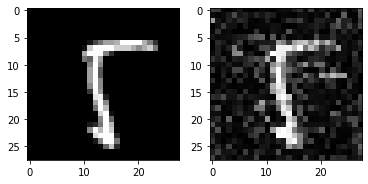

25  :  -0.22412933019234058 25
50  :  -0.2234430051612616 25
75  :  -0.18425744401882052 25
100  :  -0.16215697376867483 25
125  :  -0.03999766019115343 25
150  :  0.1663226328868983 25
175  :  0.20646919608214007 25
200  :  0.32362697430636334 25
225  :  0.3786004095566304 25
250  :  0.44968424741066065 25
275  :  0.452686434545825 25
300  :  0.46849739821619985 25
325  :  0.47730537000789475 25
350  :  0.48313048734159914 25
375  :  0.4844180769113416 25
400  :  0.4844180769113416 25
425  :  0.4885222019237798 25
450  :  0.49022408160014147 25
475  :  0.49022408160014147 25
500  :  0.49022408160014147 25
525  :  0.4904892186287237 25
550  :  0.4911336423362913 25
575  :  0.49126766134788674 25
600  :  0.4922884674771142 25
625  :  0.49236794645040804 25
650  :  0.49270798627706947 25
675  :  0.4929753982687492 25
700  :  0.49297544038146207 25
725  :  0.4931074167773846 25
750  :  0.49343023226546473 25
775  :  0.4935020225029712 25
800  :  0.49359899244196936 25
825  :  0.4936266330

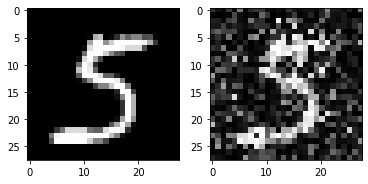

25  :  -0.07407401159773794 25
50  :  -0.0009974304403633971 25
75  :  0.019525238994361243 25
100  :  0.019355212067206837 25
125  :  0.029521778797912363 25
150  :  0.04433878006042276 25
175  :  0.06325339182875102 25
200  :  0.11627368594180626 25
225  :  0.15435544740208154 25
250  :  0.16680066506058341 25
275  :  0.26478645060022377 25
300  :  0.3229067586580946 25
325  :  0.33799992454469935 25
350  :  0.36234830430447246 25
375  :  0.390785706674417 25
400  :  0.37626765909659904 25
425  :  0.3864030073283113 25
450  :  0.3956562189243792 25
475  :  0.40850816604027856 25
500  :  0.4175359453968416 25
525  :  0.42255828223370134 25
550  :  0.4371799093593644 25
575  :  0.4369573528924698 25
600  :  0.4369573528924698 25
625  :  0.4503835025098902 25
650  :  0.4527817645559953 25
675  :  0.4551511239005406 25
700  :  0.46388461525278557 25
725  :  0.47426094954576564 25
750  :  0.4776136830167562 25
775  :  0.4776136830167562 25
800  :  0.47774536611885554 25
825  :  0.48201543

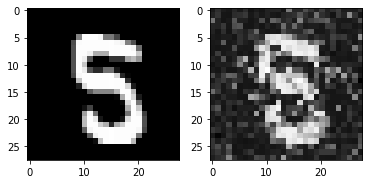

25  :  0.2248427721458838 25
50  :  0.2660712989521988 25
75  :  0.2986309419333583 25
100  :  0.3607407480859828 25
125  :  0.37072451882264523 25
150  :  0.39906209820204963 25
175  :  0.4080605734812484 25
200  :  0.44297919097548344 25
225  :  0.4657248929117972 25
250  :  0.47999894117812514 25
275  :  0.48470678088098984 25
300  :  0.48522765650829297 25
325  :  0.48600770728353254 25
350  :  0.4867146279669523 25
375  :  0.4887381711401538 25
400  :  0.48930396014566296 25
425  :  0.49028060616252794 25
450  :  0.4921493396986905 25
475  :  0.4923259167573919 25
500  :  0.49297247915791514 25
525  :  0.49297247915791514 25
550  :  0.49297247915791514 25
575  :  0.4933340275980659 25
600  :  0.49439018268726154 25
625  :  0.49439021249454956 25
650  :  0.49439021249454956 25
675  :  0.49464033857123857 25
700  :  0.49464165270758864 25
725  :  0.49474223693257996 25
750  :  0.4949021366299501 25
775  :  0.49506220385203126 25
800  :  0.495191638985506 25
825  :  0.495179825229376

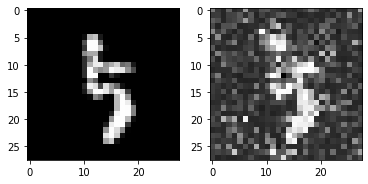

25  :  -0.4136997230206874 25
50  :  -0.4086613185106137 25
75  :  -0.37175008956051364 25
100  :  -0.29507494801096434 25
125  :  -0.3013886608273329 25
150  :  -0.23994914166150944 25
175  :  -0.19709737051773796 25
200  :  0.029847556884964765 25
225  :  0.1438534187880969 25
250  :  0.26284720454336985 25
275  :  0.2805075266298546 25
300  :  0.33859766242908274 25
325  :  0.39466773992667026 25
350  :  0.3935985265144107 25
375  :  0.3935985265144107 25
400  :  0.4111389344353968 25
425  :  0.42808575055774917 25
450  :  0.4293149329710464 25
475  :  0.426824198002202 25
500  :  0.44141143409590705 25
525  :  0.4430690846681389 25
550  :  0.4534621589096802 25
575  :  0.4660967501338871 25
600  :  0.4670914320617581 25
625  :  0.46917458401846535 25
650  :  0.4708661424031922 25
675  :  0.4727017760587808 25
700  :  0.4727107059862355 25
725  :  0.4733266601436937 25
750  :  0.4758471036814004 25
775  :  0.4758471036814004 25
800  :  0.4782940191695736 25
825  :  0.479188605803359

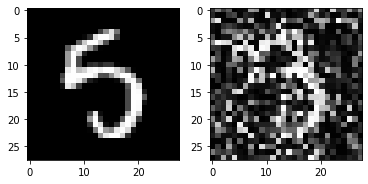

25  :  0.4289548658819731 25
50  :  0.43233815959236244 25
75  :  0.4415245911162721 25
100  :  0.4702754614067895 25
125  :  0.4726347392022396 25
150  :  0.47324321086261134 25
175  :  0.4761288009853413 25
200  :  0.48178899735314884 25
225  :  0.4816744553075819 25
250  :  0.4816744553075819 25
275  :  0.4816744553075819 25
300  :  0.484072439155689 25
325  :  0.48471971004004616 25
350  :  0.4861865532696088 25
375  :  0.4887476837833269 25
400  :  0.4893676737827136 25
425  :  0.48930689524518767 25
450  :  0.48925444928546225 25
475  :  0.48925444928546225 25
500  :  0.49018580722574107 25
525  :  0.4905875160705427 25
550  :  0.4912726775848792 25
575  :  0.49210592964824335 25
600  :  0.49227271286965524 25
625  :  0.49328188333339407 25
650  :  0.4933790662161301 25
675  :  0.4933790662161301 25
700  :  0.4933790662161301 25
725  :  0.4933790662161301 25
750  :  0.49360194676250535 25
775  :  0.49361521111609247 25
800  :  0.4936388528328415 25
825  :  0.4936388528328415 25
8

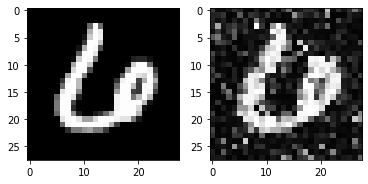

25  :  0.17489295851275705 25
50  :  0.4693927616184873 25
75  :  0.4237396544217926 25
100  :  0.42473246770892215 25
125  :  0.4594288747158838 25
150  :  0.4649606069153958 25
175  :  0.4570344711714023 25
200  :  0.46155723451354463 25
225  :  0.4707649817134619 25
250  :  0.4706069513484166 25
275  :  0.461494655263618 25
300  :  0.4270566138960006 25
325  :  0.4617057440235424 25
350  :  0.399094332923902 25
375  :  0.40666260346791616 25
400  :  0.43312118480440764 25
425  :  0.42715940699498695 25
450  :  0.4377910912395898 25
475  :  0.4402163026906589 25
500  :  0.4514246779389063 25
525  :  0.4543788520017096 25
550  :  0.4564510354146182 25
575  :  0.46298841923935946 25
600  :  0.46474590861310194 25
625  :  0.46740471969705577 25
650  :  0.472577355946332 25
675  :  0.4726560369342506 25
700  :  0.4749186063128045 25
725  :  0.4773435821208963 25
750  :  0.47968957106364496 25
775  :  0.4815317408244138 25
800  :  0.4825834247915812 25
825  :  0.48310348584138657 25
850  

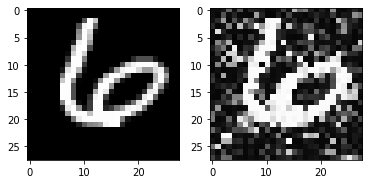

25  :  -0.20260386750195286 25
50  :  0.48386597430200107 25
75  :  0.4510124746682822 25
100  :  0.48402479489602024 25
125  :  0.48640727931784394 25
150  :  0.4878772456174739 25
175  :  0.4887692771644584 25
200  :  0.4880197067866694 25
225  :  0.4888888563526242 25
250  :  0.4891409198661645 25
275  :  0.48968637294858397 25
300  :  0.489101541115624 25
325  :  0.48857949380733223 25
350  :  0.4904153323224454 25
375  :  0.48960994994832213 25
400  :  0.49027412123446285 25
425  :  0.4902417567273959 25
450  :  0.49060121371139276 25
475  :  0.49033728557093426 25
500  :  0.4905920057331002 25
525  :  0.49037368682844307 25
550  :  0.4905383820572766 25
575  :  0.4904754530803711 25
600  :  0.49068906845771765 25
625  :  0.4908938928456506 25
650  :  0.4909676908249062 25
675  :  0.49114583770908926 25
700  :  0.4911910708021259 25
725  :  0.49155617379995226 25
750  :  0.4916581921827822 25
775  :  0.49180305676791 25
800  :  0.49180305676791 25
825  :  0.49180305676791 25
850  

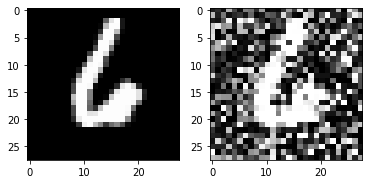

25  :  0.4147887268972443 25
50  :  0.48776042496511635 25
75  :  0.4827098087465407 25
100  :  0.49000876113397784 25
125  :  0.49065517961320587 25
150  :  0.48956073837032904 25
175  :  0.49097178348120707 25
200  :  0.49126081225812696 25
225  :  0.4916064856062893 25
250  :  0.4925835205283523 25
275  :  0.49254099463404966 25
300  :  0.49274328640201814 25
325  :  0.49263772389104593 25
350  :  0.49294070155173125 25
375  :  0.49297207631742707 25
400  :  0.4932515655817652 25
425  :  0.4932218520625413 25
450  :  0.4934223505311184 25
475  :  0.4934305756374488 25
500  :  0.4934305756374488 25
525  :  0.4934305756374488 25
550  :  0.4935629850088001 25
575  :  0.49354455854577367 25
600  :  0.4936240005873771 25
625  :  0.49363916401445357 25
650  :  0.49376141924026834 25
675  :  0.49379649657699964 25
700  :  0.4938348884808618 25
725  :  0.493866191670474 25
750  :  0.49390041444510197 25
775  :  0.4939601835291096 25
800  :  0.49396018353109716 25
825  :  0.49399903641774406

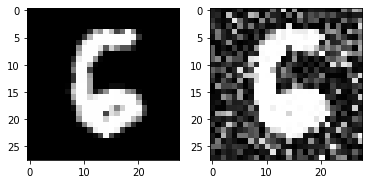

25  :  0.04553637786828864 25
50  :  0.4798437897117302 25
75  :  0.42203385823889994 25
100  :  0.4614537657064969 25
125  :  0.4852532053441514 25
150  :  0.4851440757975142 25
175  :  0.48651682289961834 25
200  :  0.4862093024407107 25
225  :  0.4854674729630103 25
250  :  0.4858840629484581 25
275  :  0.4863337145872691 25
300  :  0.48737248350106316 25
325  :  0.4876947092816077 25
350  :  0.48859255992849104 25
375  :  0.4884127008429799 25
400  :  0.48889000728504556 25
425  :  0.4891402477929637 25
450  :  0.4895220819065735 25
475  :  0.48949864139779375 25
500  :  0.4896934827022013 25
525  :  0.4899207852293352 25
550  :  0.49003282458118763 25
575  :  0.4901170194285206 25
600  :  0.4903059841122356 25
625  :  0.4903574211554776 25
650  :  0.4903288425998127 25
675  :  0.4904246082598874 25
700  :  0.4905481494455693 25
725  :  0.4905481494455693 25
750  :  0.490600960352766 25
775  :  0.49071137762474243 25
800  :  0.49075565884681716 25
825  :  0.49078293680669977 25
850

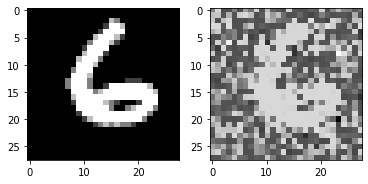

25  :  0.42452628309414475 25
50  :  0.4812803989468681 25
75  :  0.47531248090592887 25
100  :  0.46707872146014057 25
125  :  0.48003065844690945 25
150  :  0.4844428200810651 25
175  :  0.4842319171707226 25
200  :  0.4848143800102689 25
225  :  0.48666254325206504 25
250  :  0.4869536192920118 25
275  :  0.4864491975557223 25
300  :  0.4872639479925957 25
325  :  0.48747511721082526 25
350  :  0.4877385605840493 25
375  :  0.4878029120090355 25
400  :  0.4879655628485345 25
425  :  0.4881298966889558 25
450  :  0.4882884458497941 25
475  :  0.4884755247486637 25
500  :  0.48871490067385 25
525  :  0.48873297884261685 25
550  :  0.4888103519084375 25
575  :  0.48939511341460207 25
600  :  0.48961114106166786 25
625  :  0.4896669004500286 25
650  :  0.4900041947126038 25
675  :  0.4900041947126038 25
700  :  0.4900393619930811 25
725  :  0.49028303799087547 25
750  :  0.4904007123147133 25
775  :  0.49044304052756066 25
800  :  0.49064638262331106 25
825  :  0.4906610312807071 25
850

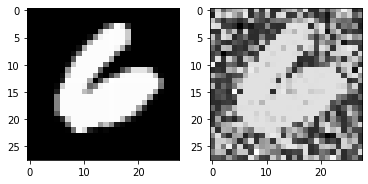

25  :  0.4877067008363491 25
50  :  0.4909402390015622 25
75  :  0.4887509151433677 25
100  :  0.4923305108846714 25
125  :  0.49118420203215474 25
150  :  0.49155027752735236 25
175  :  0.49277027837534876 25
200  :  0.4921125572627351 25
225  :  0.49305273455775855 25
250  :  0.4928944808409378 25
275  :  0.49336305427394106 25
300  :  0.49335387072239356 25
325  :  0.4933760893522997 25
350  :  0.49348508556381093 25
375  :  0.4934489671347655 25
400  :  0.4936065576039467 25
425  :  0.4937058735713856 25
450  :  0.49392492161269796 25
475  :  0.494027270928417 25
500  :  0.4940281322993565 25
525  :  0.4940281322993565 25
550  :  0.49412430415219155 25
575  :  0.4941642512964412 25
600  :  0.49423768415947733 25
625  :  0.4943065228986084 25
650  :  0.49430448911938796 25
675  :  0.4943050357237803 25
700  :  0.49435179097877013 25
725  :  0.4943583346612567 25
750  :  0.49439205854314217 25
775  :  0.4944448199114708 25
800  :  0.4944559784491705 25
Time:  67.86350703239441  secon

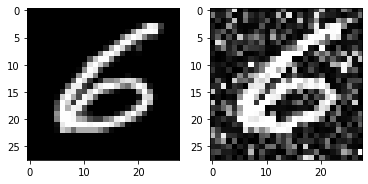

25  :  0.4053969781537562 25
50  :  0.48627332755838326 25
75  :  0.4673818797446754 25
100  :  0.4808617317026277 25
125  :  0.488004921585614 25
150  :  0.4869920753667933 25
175  :  0.4883721231418058 25
200  :  0.4870876625769383 25
225  :  0.4869618995777752 25
250  :  0.4880566897455296 25
275  :  0.4885772832435304 25
300  :  0.48873806772057216 25
325  :  0.4888401895772308 25
350  :  0.48881985007596407 25
375  :  0.4894442907515092 25
400  :  0.48962146385843014 25
425  :  0.4901156183349669 25
450  :  0.49039006617093606 25
475  :  0.49039006617093606 25
500  :  0.4906809280632627 25
525  :  0.4908568609078308 25
550  :  0.4908568609078308 25
575  :  0.4908925816961266 25
600  :  0.4909548949690668 25
625  :  0.4910722339068919 25
650  :  0.4911666631614367 25
675  :  0.4911924547253849 25
700  :  0.4912243252840223 25
725  :  0.4912505492188168 25
750  :  0.491334292018369 25
775  :  0.49137444691523324 25
800  :  0.4914648714565641 25
825  :  0.4914615101598615 25
850  :  

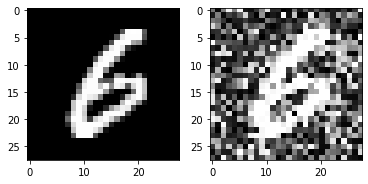

25  :  -0.45022890754197614 25
50  :  0.33040235678294494 25
75  :  0.3269500412287205 25
100  :  0.410596828203757 25
125  :  0.48273717826317647 25
150  :  0.48367142851277595 25
175  :  0.48314659773079216 25
200  :  0.4852780705107508 25
225  :  0.48664545189940184 25
250  :  0.487727732791222 25
275  :  0.4869510724493413 25
300  :  0.4869510724493413 25
325  :  0.48842951547143393 25
350  :  0.48787945399438176 25
375  :  0.48845908592200143 25
400  :  0.4884341776930998 25
425  :  0.4891236397811374 25
450  :  0.4888405689132218 25
475  :  0.4896666004338187 25
500  :  0.4896314957425458 25
525  :  0.48961534510763677 25
550  :  0.48961534510763677 25
575  :  0.49008633391544865 25
600  :  0.4904739858254509 25
625  :  0.4904739858254509 25
650  :  0.4904739858254509 25
675  :  0.49055680869105484 25
700  :  0.49061876577772456 25
725  :  0.49075497564247295 25
750  :  0.49102989520913753 25
775  :  0.49103547205167897 25
800  :  0.49104535223057877 25
825  :  0.4911303384747216

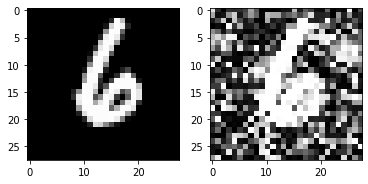

25  :  0.46379321413283825 25
50  :  0.48985838638867535 25
75  :  0.4888201064024942 25
100  :  0.48794897045979596 25
125  :  0.49015982553046655 25
150  :  0.48962830682123554 25
175  :  0.49225753239773273 25
200  :  0.49198431008528637 25
225  :  0.4916110794046286 25
250  :  0.4921294675939014 25
275  :  0.49259665636494926 25
300  :  0.49278985950593346 25
325  :  0.4931811089900921 25
350  :  0.49341412070175655 25
375  :  0.4933173201600034 25
400  :  0.4933173201600034 25
425  :  0.4934514951559342 25
450  :  0.4935862290058272 25
475  :  0.493700335895885 25
500  :  0.4938056464659736 25
525  :  0.49380536448702333 25
550  :  0.49381080214669837 25
575  :  0.49397073886550713 25
600  :  0.49404328620054744 25
625  :  0.4940470345338487 25
650  :  0.494066519222662 25
675  :  0.49414435875434654 25
700  :  0.494145940604203 25
725  :  0.494145940604203 25
750  :  0.4941605179229079 25
775  :  0.4941928109693547 25
800  :  0.4942195796447976 25
825  :  0.4942570102515508 25
Ti

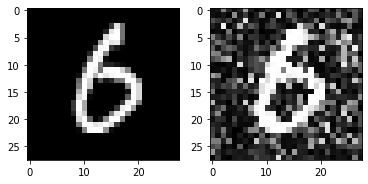

25  :  0.3174465749937746 25
50  :  0.4586922555328009 25
75  :  0.3858364715884125 25
100  :  0.37923138892557257 25
125  :  0.47120829853801016 25
150  :  0.4684488531476793 25
175  :  0.48066912350387786 25
200  :  0.4811263969908488 25
225  :  0.481786324031098 25
250  :  0.482862504907972 25
275  :  0.48242519456453375 25
300  :  0.4833603032424011 25
325  :  0.48586386762316525 25
350  :  0.486778828911867 25
375  :  0.48564730215461555 25
400  :  0.4868501227918138 25
425  :  0.4873719719438105 25
450  :  0.48743425979293264 25
475  :  0.4881855864951307 25
500  :  0.48821389678573507 25
525  :  0.48843543624829416 25
550  :  0.4885894540936535 25
575  :  0.48891995216480344 25
600  :  0.4890624195206921 25
625  :  0.4894281743964328 25
650  :  0.48935156691576526 25
675  :  0.48935156691576526 25
700  :  0.48944311882241975 25
725  :  0.48972726032767266 25
750  :  0.4898554531334028 25
775  :  0.48990338502227376 25
800  :  0.4899416413514245 25
825  :  0.4900215275178894 25
8

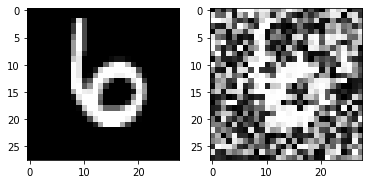

25  :  -0.06157395896413065 25
50  :  0.4847058910750145 25
75  :  0.4644305807184608 25
100  :  0.4841179093474952 25
125  :  0.4849032101079339 25
150  :  0.48637429030506796 25
175  :  0.48725033357406256 25
200  :  0.4863916726200954 25
225  :  0.48708774930839366 25
250  :  0.4881929098027255 25
275  :  0.4893678737389358 25
300  :  0.4894587387240883 25
325  :  0.4894587387240883 25
350  :  0.4894587387240883 25
375  :  0.4894587387240883 25
400  :  0.4899155276560781 25
425  :  0.4900716008297601 25
450  :  0.49021047238400167 25
475  :  0.4905772077239094 25
500  :  0.4908241813756302 25
525  :  0.4908241813756302 25
550  :  0.4911041622196494 25
575  :  0.49115931102063937 25
600  :  0.49121308752157655 25
625  :  0.49121308752157655 25
650  :  0.4912198743317813 25
675  :  0.49126173469228285 25
700  :  0.4913834600162288 25
725  :  0.49147449493173895 25
750  :  0.4914831636924181 25
775  :  0.491491886541825 25
800  :  0.49154304638757695 25
825  :  0.4916065790032818 25
85

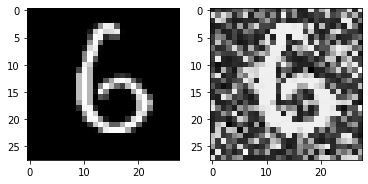

25  :  0.401716715553897 25
50  :  0.4811411963920846 25
75  :  0.4452489098518302 25
100  :  0.4588965024659522 25
125  :  0.46682621573270466 25
150  :  0.4785310705254606 25
175  :  0.46554165017617954 25
200  :  0.46497718549713324 25
225  :  0.4536466065518175 25
250  :  0.4542345190331848 25
275  :  0.46828441150338074 25
300  :  0.4747936176668097 25
325  :  0.4750307975326902 25
350  :  0.47715428842981067 25
375  :  0.48296626004367466 25
400  :  0.4826808212751502 25
425  :  0.4826808212751502 25
450  :  0.48726648068364425 25
475  :  0.487892135376783 25
500  :  0.488646382518347 25
525  :  0.48860944628477 25
550  :  0.48861943850512485 25
575  :  0.48885078404273036 25
600  :  0.48921093742828825 25
625  :  0.49076397256098225 25
650  :  0.49076397256098225 25
675  :  0.4909403814644109 25
700  :  0.49155686627261963 25
725  :  0.49169763810231204 25
750  :  0.4925806771112651 25
775  :  0.4925806771112651 25
800  :  0.4925806771112651 25
825  :  0.4925806771112651 25
850 

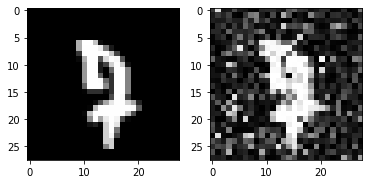

25  :  0.2670179565392342 25
50  :  0.46583126096965216 25
75  :  0.4401195157683017 25
100  :  0.4182568838075338 25
125  :  0.4109167808559701 25
150  :  0.4494082721487689 25
175  :  0.4569732611557806 25
200  :  0.4570394467160236 25
225  :  0.4594002301189596 25
250  :  0.46566893264513226 25
275  :  0.4519460858205655 25
300  :  0.4507879613087934 25
325  :  0.4681109782226191 25
350  :  0.45733790221396237 25
375  :  0.45742958447344356 25
400  :  0.4609786316550123 25
425  :  0.47622701182356375 25
450  :  0.47439727670759757 25
475  :  0.4762505663290441 25
500  :  0.47600550357237364 25
525  :  0.47640178362681385 25
550  :  0.4774974282668434 25
575  :  0.48042988779207074 25
600  :  0.4843791877111634 25
625  :  0.48493904446615754 25
650  :  0.48859900976240783 25
675  :  0.48943316073250076 25
700  :  0.4892943282721686 25
725  :  0.48947105815982134 25
750  :  0.4897889639768512 25
775  :  0.49105632484994843 25
800  :  0.4911420868205064 25
825  :  0.49118334914736617 2

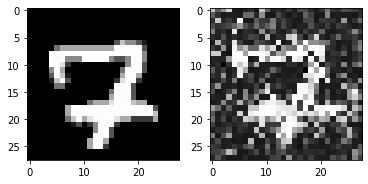

25  :  -0.23114181770014447 25
50  :  0.4446462448766092 25
75  :  0.18071609771407382 25
100  :  0.3232488616469158 25
125  :  0.3989356386640712 25
150  :  0.4275889845580946 25
175  :  0.43070151332477163 25
200  :  0.44357987014788086 25
225  :  0.4575802691663634 25
250  :  0.4575802691663634 25
275  :  0.45885768854542763 25
300  :  0.4628156470060777 25
325  :  0.46404821091020054 25
350  :  0.4681099519621155 25
375  :  0.4666149525980897 25
400  :  0.4715508160863034 25
425  :  0.47025433985830406 25
450  :  0.4760556408801436 25
475  :  0.48156744269943486 25
500  :  0.48206431242311887 25
525  :  0.48230493152597537 25
550  :  0.4853719202610827 25
575  :  0.4854094726929804 25
600  :  0.48588069840167686 25
625  :  0.48628978052774174 25
650  :  0.4872315327989222 25
675  :  0.4875627192325223 25
700  :  0.487610245892645 25
725  :  0.48818017203714337 25
750  :  0.488164851871814 25
775  :  0.4883517649739389 25
800  :  0.4887701072709649 25
825  :  0.4887672375738581 25
8

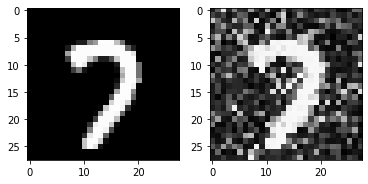

25  :  -0.4605096191191362 25
50  :  -0.1504820385934601 25
75  :  -0.45428178023341625 25
100  :  0.05458757112508822 25
125  :  0.4164702095413926 25
150  :  0.4516477901001743 25
175  :  0.48396712263881353 25
200  :  0.48316516254913966 25
225  :  0.4841321855713865 25
250  :  0.48405834621505206 25
275  :  0.4870033561364522 25
300  :  0.48620891107193875 25
325  :  0.48677632813876764 25
350  :  0.4871182970491863 25
375  :  0.4864132362290097 25
400  :  0.48711340435084827 25
425  :  0.4880471008573283 25
450  :  0.48806894659006844 25
475  :  0.4892381651853409 25
500  :  0.4891078808302223 25
525  :  0.48934245664988185 25
550  :  0.48934245664988185 25
575  :  0.48934245664988185 25
600  :  0.48934245664988185 25
625  :  0.48934245664988185 25
650  :  0.4893774787914438 25
675  :  0.4896010907903736 25
700  :  0.48968605140276145 25
725  :  0.48968605140276145 25
750  :  0.48968605140276145 25
775  :  0.489813921524901 25
800  :  0.48977447479814346 25
825  :  0.4897645880718

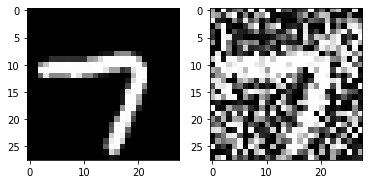

25  :  -0.44519049821152523 25
50  :  0.10632767933879989 25
75  :  -0.12298344318364295 25
100  :  0.09645111058021186 25
125  :  0.3329487094164617 25
150  :  0.4510805772905173 25
175  :  0.4437498173149841 25
200  :  0.4575078461495916 25
225  :  0.4691884273087233 25
250  :  0.4739226414683146 25
275  :  0.48150145461111216 25
300  :  0.48334368369427133 25
325  :  0.4836491129373991 25
350  :  0.4833692155862451 25
375  :  0.48276898462126183 25
400  :  0.48297466094942654 25
425  :  0.4835603926010991 25
450  :  0.4842647681694685 25
475  :  0.48418988139350344 25
500  :  0.48494667424122195 25
525  :  0.4854378232585772 25
550  :  0.4852512789970967 25
575  :  0.4861962693596894 25
600  :  0.48569510020503265 25
625  :  0.48620642948225723 25
650  :  0.4863137641024066 25
675  :  0.48670185491799384 25
700  :  0.48676069836889346 25
725  :  0.48672059495293646 25
750  :  0.4871157526593056 25
775  :  0.487130654672423 25
800  :  0.4871752170679064 25
825  :  0.48709685876901027

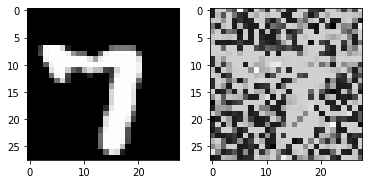

25  :  0.2666837879915398 25
50  :  0.2985355847360631 25
75  :  0.2775264080864193 25
100  :  0.3247018553007251 25
125  :  0.32637788806348966 25
150  :  0.35823228193954154 25
175  :  0.37279503647680123 25
200  :  0.4017030571151853 25
225  :  0.39891916219624 25
250  :  0.4116508993843786 25
275  :  0.43056825328302617 25
300  :  0.42334387572823656 25
325  :  0.4386013444611676 25
350  :  0.4434634202189476 25
375  :  0.45836686764449 25
400  :  0.45884433891568877 25
425  :  0.4560080324456397 25
450  :  0.4595090436043578 25
475  :  0.4546089467350761 25
500  :  0.4666883536980417 25
525  :  0.4672142874455141 25
550  :  0.4656282522859127 25
575  :  0.4773486356903028 25
600  :  0.4791769258803395 25
625  :  0.477530153528106 25
650  :  0.477530153528106 25
675  :  0.4793349204083281 25
700  :  0.4836989893510747 25
725  :  0.4826876186609593 25
750  :  0.48347185697392836 25
775  :  0.4866392355590453 25
800  :  0.48641340967414287 25
825  :  0.4894001245139775 25
850  :  0.4

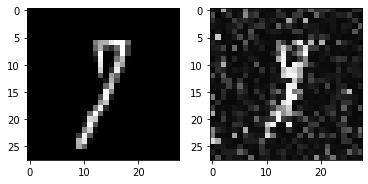

25  :  0.2829886603913781 25
50  :  0.4103157390374632 25
75  :  0.3543065972676663 25
100  :  0.41516996093388225 25
125  :  0.4264307616498784 25
150  :  0.4368283917108867 25
175  :  0.4621804750164169 25
200  :  0.4741527400407119 25
225  :  0.4738006978722215 25
250  :  0.4802968508156952 25
275  :  0.48390568307195503 25
300  :  0.49027901187079637 25
325  :  0.491377426356696 25
350  :  0.49042388591177744 25
375  :  0.4904334170012511 25
400  :  0.49056581388158543 25
425  :  0.49102400626511666 25
450  :  0.49098163907264575 25
475  :  0.4914523897818377 25
500  :  0.4918080292319113 25
525  :  0.4919778648013928 25
550  :  0.4921165883063322 25
575  :  0.4927185760217651 25
600  :  0.49271525793015397 25
625  :  0.4928515560305137 25
650  :  0.49307154837046885 25
675  :  0.49319122000824145 25
700  :  0.4934397460049073 25
725  :  0.49353775783410136 25
750  :  0.49358101448798186 25
775  :  0.4937090120157655 25
800  :  0.49371630037138026 25
825  :  0.49391731650590187 25


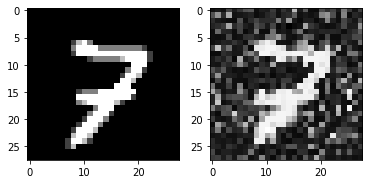

25  :  0.021996236231257085 25
50  :  0.4747865150107783 25
75  :  0.34108135467940714 25
100  :  0.39563849535037554 25
125  :  0.4031998773130806 25
150  :  0.47554198121052005 25
175  :  0.4862588348434424 25
200  :  0.488110343495516 25
225  :  0.487907179830541 25
250  :  0.4880582141239154 25
275  :  0.488124144196438 25
300  :  0.48846407393925767 25
325  :  0.4897181236272146 25
350  :  0.4898779401118941 25
375  :  0.4896528192661936 25
400  :  0.4897879749304127 25
425  :  0.490004169375254 25
450  :  0.49045449552372217 25
475  :  0.49045437294865646 25
500  :  0.49045437294865646 25
525  :  0.490565586045178 25
550  :  0.4906017435883848 25
575  :  0.4908975518648511 25
600  :  0.49089215805536524 25
625  :  0.4909748480916205 25
650  :  0.4909683798466497 25
675  :  0.4910773993641493 25
700  :  0.49119925645098655 25
725  :  0.4911837392426657 25
750  :  0.4912207729054756 25
775  :  0.49126872094519247 25
800  :  0.4912632682003652 25
825  :  0.49130709573403863 25
850  

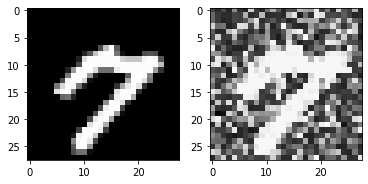

25  :  -0.4413915169380617 25
50  :  -0.046127989906953215 25
75  :  -0.3715671235861853 25
100  :  -0.21392003046136243 25
125  :  0.2798592494948327 25
150  :  0.42547186325275543 25
175  :  0.47226046637879127 25
200  :  0.48001338038153873 25
225  :  0.48134888845607404 25
250  :  0.4820133705843865 25
275  :  0.4828024533304786 25
300  :  0.4822546875673324 25
325  :  0.48294943222829434 25
350  :  0.483799165159262 25
375  :  0.4835357530736638 25
400  :  0.48402153991756175 25
425  :  0.48479116267447175 25
450  :  0.48507476113790987 25
475  :  0.4851371660383919 25
500  :  0.4851375656878022 25
525  :  0.48546740385535314 25
550  :  0.48584357772000974 25
575  :  0.48577032711821344 25
600  :  0.4863626582699913 25
625  :  0.48690308023834195 25
650  :  0.48730934474678866 25
675  :  0.4873476930687156 25
700  :  0.48740908040505304 25
725  :  0.4873476930687156 25
750  :  0.4873991235510758 25
775  :  0.4876429473165549 25
800  :  0.4876954152917995 25
825  :  0.4876954152917

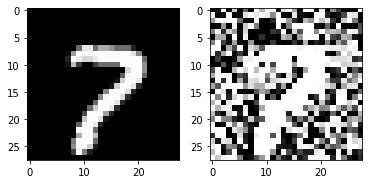

25  :  -0.4389973808636753 25
50  :  -0.05333641754079188 25
75  :  -0.2707390147616981 25
100  :  0.05456458558924413 25
125  :  0.23877146247776218 25
150  :  0.4420682324626615 25
175  :  0.4113629176440302 25
200  :  0.4569297690799017 25
225  :  0.4326875330265847 25
250  :  0.432835862670656 25
275  :  0.4414912471124675 25
300  :  0.44604240003758394 25
325  :  0.45248342839146655 25
350  :  0.46225962917082963 25
375  :  0.46818187342007855 25
400  :  0.47120491696696437 25
425  :  0.48168531521534386 25
450  :  0.48168586101284844 25
475  :  0.48168586101284844 25
500  :  0.48343889886355146 25
525  :  0.48412304786986904 25
550  :  0.4847941327207194 25
575  :  0.4866672821876538 25
600  :  0.4868988319581549 25
625  :  0.4872724465566378 25
650  :  0.4876483815748055 25
675  :  0.48777104746725763 25
700  :  0.4879011972400569 25
725  :  0.4882107878348577 25
750  :  0.48829740787274717 25
775  :  0.4888049704318455 25
800  :  0.48880325260044244 25
825  :  0.488803252600442

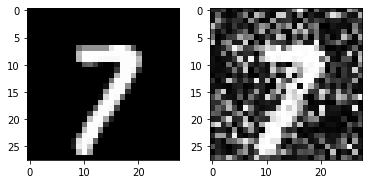

25  :  -0.24273548194594896 25
50  :  0.14700235154921573 25
75  :  -0.11204641400309487 25
100  :  0.2361464444424434 25
125  :  0.38442918618017985 25
150  :  0.47357203928886077 25
175  :  0.4858706749065289 25
200  :  0.4891773658548812 25
225  :  0.4891820296596603 25
250  :  0.49039688315120095 25
275  :  0.4917642670859211 25
300  :  0.49227285122124476 25
325  :  0.49363084890629494 25
350  :  0.4936390851365596 25
375  :  0.4938057088712277 25
400  :  0.4940970940114695 25
425  :  0.49414039312470437 25
450  :  0.49414039312470437 25
475  :  0.49414039312470437 25
500  :  0.4944829239638355 25
525  :  0.4944829239638355 25
550  :  0.4946202438620038 25
575  :  0.49471810159940477 25
600  :  0.4947891754308022 25
625  :  0.4947891754308022 25
650  :  0.4947891754308022 25
675  :  0.4948053478768845 25
700  :  0.49482393034195044 25
725  :  0.494840410199206 25
750  :  0.4948639722671812 25
775  :  0.49494294091032337 25
800  :  0.4949418124710301 25
825  :  0.49499586610697366 

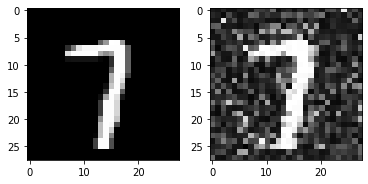

25  :  -0.4820441009986766 25
50  :  -0.37399241798935845 25
75  :  -0.253033008050153 25
100  :  -0.17086764587482414 25
125  :  0.290551765874411 25
150  :  0.4570691549922215 25
175  :  0.4849746234844201 25
200  :  0.4860956221560967 25
225  :  0.48597695077784664 25
250  :  0.4872364362432428 25
275  :  0.48774921670153704 25
300  :  0.4885525608905973 25
325  :  0.48869728187332373 25
350  :  0.48931994469821277 25
375  :  0.49044888934033415 25
400  :  0.4909002594479027 25
425  :  0.4910584484105281 25
450  :  0.491576264312613 25
475  :  0.49204539775306816 25
500  :  0.4928822934127095 25
525  :  0.4928822934127095 25
550  :  0.49317409203211027 25
575  :  0.4932815498736799 25
600  :  0.49326981224406924 25
625  :  0.4932965137945108 25
650  :  0.49332163255020445 25
675  :  0.49337075089006743 25
700  :  0.4934184605145029 25
725  :  0.49350625031080775 25
750  :  0.4936044771342599 25
775  :  0.49363308557364644 25
800  :  0.49371817812245555 25
825  :  0.4938257618550108 

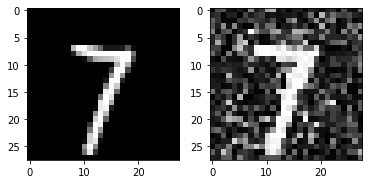

25  :  -0.3034178519205265 25
50  :  0.13948149404923102 25
75  :  0.2607668408815261 25
100  :  0.3817360073583319 25
125  :  0.4298072532574459 25
150  :  0.44979923511851616 25
175  :  0.44979923511851616 25
200  :  0.4533177810215703 25
225  :  0.4648929081590931 25
250  :  0.470047436335011 25
275  :  0.47245308354225063 25
300  :  0.4776699175185925 25
325  :  0.48131181738610257 25
350  :  0.4838822030259587 25
375  :  0.48527243130107434 25
400  :  0.48520257889947216 25
425  :  0.48823591887243384 25
450  :  0.4881375039823975 25
475  :  0.48849731564775 25
500  :  0.48981572620151614 25
525  :  0.49008044243157844 25
550  :  0.49010508570472816 25
575  :  0.49125725361196393 25
600  :  0.4917192792342817 25
625  :  0.4917004126065435 25
650  :  0.49196738761016134 25
675  :  0.49197088174308745 25
700  :  0.49238996504629834 25
725  :  0.49271521811688423 25
750  :  0.4930936701843904 25
775  :  0.4931448984429443 25
800  :  0.4933594889166137 25
825  :  0.4933367420459487 25

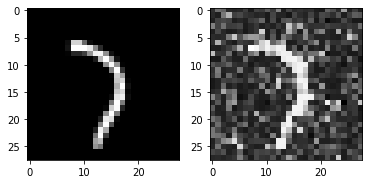

25  :  0.030454730695365834 25
50  :  0.47545202035488393 25
75  :  0.48510749467030834 25
100  :  0.48231964233768143 25
125  :  0.4853442143351745 25
150  :  0.48635880021334726 25
175  :  0.48662692032692767 25
200  :  0.487055482017298 25
225  :  0.4853826999130713 25
250  :  0.4884643865527533 25
275  :  0.49067826695808 25
300  :  0.4911035624523515 25
325  :  0.49101277220443823 25
350  :  0.4901258592691102 25
375  :  0.49138078103120403 25
400  :  0.49067136773277553 25
425  :  0.49036722898460433 25
450  :  0.490240456115684 25
475  :  0.49075139495161085 25
500  :  0.490581485847299 25
525  :  0.4905876902658381 25
550  :  0.4907062240615166 25
575  :  0.490621437612671 25
600  :  0.490743663432202 25
625  :  0.49082525010258854 25
650  :  0.4910025906399985 25
675  :  0.49109305663690905 25
700  :  0.49106281410711117 25
725  :  0.49107258269550325 25
750  :  0.4911140358077969 25
775  :  0.49119557544773773 25
800  :  0.4912027001132498 25
825  :  0.49120790659569336 25
Ti

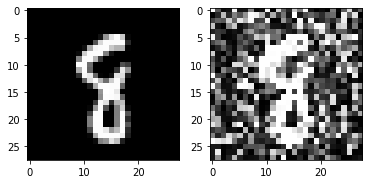

25  :  -0.2376079814308151 25
50  :  0.46733151987720717 25
75  :  0.3475939773194345 25
100  :  0.4393414910217388 25
125  :  0.4705419028646105 25
150  :  0.4630969591287152 25
175  :  0.47943235919764887 25
200  :  0.4810388463460458 25
225  :  0.48307695494313757 25
250  :  0.4824999797132506 25
275  :  0.48312050783714 25
300  :  0.48390585938421293 25
325  :  0.48536773730796084 25
350  :  0.48644036742257335 25
375  :  0.48668607391820384 25
400  :  0.4874800872801368 25
425  :  0.4885518345414617 25
450  :  0.48844706004888594 25
475  :  0.48886415051252363 25
500  :  0.4894593436691471 25
525  :  0.4897784419292051 25
550  :  0.4897071997301924 25
575  :  0.4897295741734803 25
600  :  0.4897295741734803 25
625  :  0.4898447829690665 25
650  :  0.48983296363090606 25
675  :  0.4898961424817291 25
700  :  0.4900094709242787 25
725  :  0.49008293328189084 25
750  :  0.490090276565452 25
775  :  0.4902385327903683 25
800  :  0.49035420254326106 25
825  :  0.4905655285137591 25
850

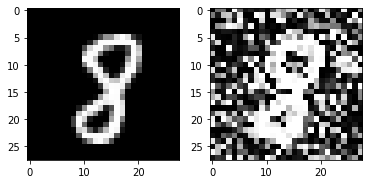

25  :  -0.03305739637758581 25
50  :  0.48076045615218316 25
75  :  0.4683849071472599 25
100  :  0.4573021561313722 25
125  :  0.44035723137028665 25
150  :  0.4775490252398637 25
175  :  0.4744783265095895 25
200  :  0.4798884282040757 25
225  :  0.48021105550491594 25
250  :  0.48223149134967475 25
275  :  0.4818530416758976 25
300  :  0.48325951657249616 25
325  :  0.48342483950170534 25
350  :  0.4842943019244302 25
375  :  0.4858161271776862 25
400  :  0.48631502419505157 25
425  :  0.48626298581786653 25
450  :  0.48672181717491736 25
475  :  0.4869137065537787 25
500  :  0.4868409299103923 25
525  :  0.48721951041792166 25
550  :  0.48728249398764517 25
575  :  0.48727204691476067 25
600  :  0.4874822934565169 25
625  :  0.4876212764736114 25
650  :  0.4874340320957517 25
675  :  0.48750099970077193 25
700  :  0.4877111955604375 25
725  :  0.4877111955604375 25
750  :  0.4877360372386043 25
775  :  0.48796104385702493 25
800  :  0.4881543412545901 25
825  :  0.4881766157923649 

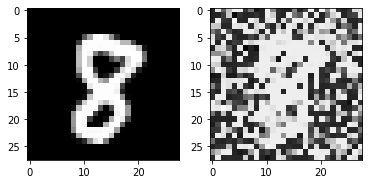

25  :  0.2390556690884823 25
50  :  0.48668407003645925 25
75  :  0.4804102895677123 25
100  :  0.4853971733340845 25
125  :  0.48778551194450886 25
150  :  0.48854106778919 25
175  :  0.4886553796786127 25
200  :  0.4877811623685659 25
225  :  0.48776487900043025 25
250  :  0.4872754614598236 25
275  :  0.4900832416820942 25
300  :  0.4887061025691343 25
325  :  0.48918457969058515 25
350  :  0.4893897652576074 25
375  :  0.4900321587687725 25
400  :  0.4901346005180003 25
425  :  0.49066281050953875 25
450  :  0.49091199251179457 25
475  :  0.49086807232791474 25
500  :  0.49134373337610604 25
525  :  0.49132037512935095 25
550  :  0.49132037512935095 25
575  :  0.49147959774472594 25
600  :  0.49147478462425453 25
625  :  0.49149799482550954 25
650  :  0.4915614218805028 25
675  :  0.49155143368076093 25
700  :  0.4916410836519871 25
725  :  0.49170051632803335 25
750  :  0.4917548845129822 25
775  :  0.4918439348524746 25
800  :  0.49183938032463576 25
825  :  0.49183938032463576 2

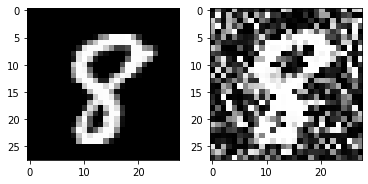

25  :  -0.12438239830818959 25
50  :  0.4686877867094632 25
75  :  0.4596727555408127 25
100  :  0.46641919637046003 25
125  :  0.4720962846636582 25
150  :  0.4765313140882375 25
175  :  0.4868904009825359 25
200  :  0.4870716444401101 25
225  :  0.48755675530522663 25
250  :  0.48832567219152934 25
275  :  0.4882012715642926 25
300  :  0.488846826877625 25
325  :  0.48853528247431105 25
350  :  0.4881728076714333 25
375  :  0.48910154300153413 25
400  :  0.49002285388081634 25
425  :  0.48993858016808534 25
450  :  0.4907851528311062 25
475  :  0.49047435171055426 25
500  :  0.49013214840636815 25
525  :  0.4904215117711275 25
550  :  0.49075864819684367 25
575  :  0.49061219796517097 25
600  :  0.49074992136402495 25
625  :  0.49081928435471933 25
650  :  0.4909171425589026 25
675  :  0.4912872181997376 25
700  :  0.49143393850239586 25
725  :  0.49143393850239586 25
750  :  0.49157968335591695 25
775  :  0.491576864532993 25
800  :  0.49173861589967044 25
825  :  0.4917684762201297

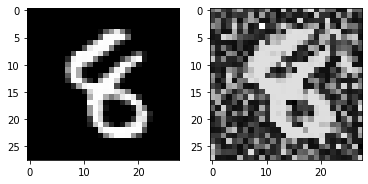

25  :  0.34862814484988974 25
50  :  0.48022247263236756 25
75  :  0.4750314120632364 25
100  :  0.4765982193362064 25
125  :  0.48122353502776166 25
150  :  0.48043215549394597 25
175  :  0.4816647642484251 25
200  :  0.4821539888685694 25
225  :  0.48475174862402864 25
250  :  0.48155749460541325 25
275  :  0.4851361921048078 25
300  :  0.48503429809870324 25
325  :  0.4859114081741831 25
350  :  0.48634483073611295 25
375  :  0.4871592148110817 25
400  :  0.4872350893834235 25
425  :  0.48676225522398714 25
450  :  0.48793157793138836 25
475  :  0.4881881672203216 25
500  :  0.48885253205743334 25
525  :  0.4885976605996867 25
550  :  0.4893287755652305 25
575  :  0.4899563886350641 25
600  :  0.4900175772787582 25
625  :  0.4902041196103884 25
650  :  0.49018975421928473 25
675  :  0.4902262226406149 25
700  :  0.490219603234592 25
725  :  0.4902427420276852 25
750  :  0.49049751400967945 25
775  :  0.4905271146453365 25
800  :  0.49054776764729763 25
825  :  0.4905943424802506 25


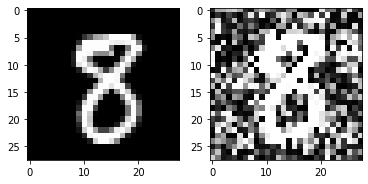

25  :  0.11271041407454875 25
50  :  0.4795685756944381 25
75  :  0.4353699653800272 25
100  :  0.4628582562542025 25
125  :  0.46635056512666523 25
150  :  0.4773181925905635 25
175  :  0.48036919838167164 25
200  :  0.4777352213700601 25
225  :  0.4810555573754308 25
250  :  0.481551528300615 25
275  :  0.4851691418496171 25
300  :  0.4841334009233887 25
325  :  0.4837582347656323 25
350  :  0.48615785594604405 25
375  :  0.4867959173268292 25
400  :  0.4879243997985827 25
425  :  0.48849650144000484 25
450  :  0.48823210876931145 25
475  :  0.48913751601245764 25
500  :  0.48862146505279147 25
525  :  0.48968259859143776 25
550  :  0.4897632566163067 25
575  :  0.4899231780167463 25
600  :  0.4902624274341195 25
625  :  0.4902624274341195 25
650  :  0.4902624274341195 25
675  :  0.4904976015406051 25
700  :  0.49054142762583713 25
725  :  0.49054142762583713 25
750  :  0.49058961033567194 25
775  :  0.4908956127883871 25
800  :  0.4909238451786228 25
825  :  0.4909238451786228 25
85

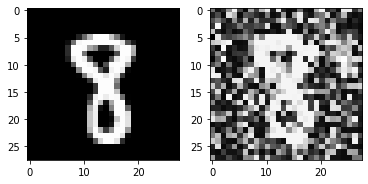

25  :  0.18507036409973945 25
50  :  0.4759055556696538 25
75  :  0.39847065701536477 25
100  :  0.35225470965039274 25
125  :  0.37200785570539424 25
150  :  0.43904121887011077 25
175  :  0.47449965561218144 25
200  :  0.4777554437783957 25
225  :  0.48148172270365924 25
250  :  0.4826872726011508 25
275  :  0.4832877357900451 25
300  :  0.4830056025940518 25
325  :  0.4840360572863761 25
350  :  0.4855297809859707 25
375  :  0.48619258780332586 25
400  :  0.4864876314828395 25
425  :  0.4872694321677298 25
450  :  0.48735947911371263 25
475  :  0.4878618456871587 25
500  :  0.48786855124135237 25
525  :  0.48809243427047544 25
550  :  0.48810696120393376 25
575  :  0.48816394834776383 25
600  :  0.48823173026772626 25
625  :  0.48830179686866093 25
650  :  0.48854547202893867 25
675  :  0.4885151295174507 25
700  :  0.4886192898896753 25
725  :  0.4888849186319574 25
750  :  0.48888387149311885 25
775  :  0.48896754719967434 25
800  :  0.4892803114692815 25
825  :  0.489291378678782

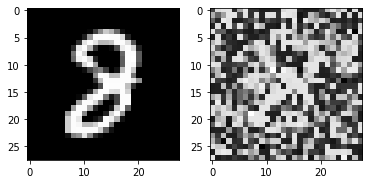

25  :  0.4757623897387448 25
50  :  0.49155511164155574 25
75  :  0.48925848627846347 25
100  :  0.49071465811747816 25
125  :  0.48918070373330375 25
150  :  0.4891492849268429 25
175  :  0.48881976290715096 25
200  :  0.49047499943847017 25
225  :  0.4876645163462421 25
250  :  0.488038833353197 25
275  :  0.4880474254940612 25
300  :  0.48884561845700975 25
325  :  0.4889336007375525 25
350  :  0.48900195724398393 25
375  :  0.48940263492345226 25
400  :  0.489534532611767 25
425  :  0.48978001610964694 25
450  :  0.4898428148613611 25
475  :  0.49030703264467945 25
500  :  0.49005877001741677 25
525  :  0.4901099550592531 25
550  :  0.49050939019565126 25
575  :  0.49064906901945027 25
600  :  0.49088435268409486 25
625  :  0.4909963619406157 25
650  :  0.4909963619406157 25
675  :  0.4909963619406157 25
700  :  0.49101148367809955 25
725  :  0.49132645633172534 25
750  :  0.49132149293789623 25
775  :  0.4914641346248583 25
800  :  0.4914737280260009 25
825  :  0.491483579167013 2

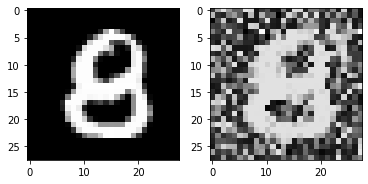

25  :  0.19748041727707621 25
50  :  0.47503040323951035 25
75  :  0.41196986655626144 25
100  :  0.4688114863187982 25
125  :  0.4739754877052844 25
150  :  0.48170901692305085 25
175  :  0.48742767141399324 25
200  :  0.48519009603221064 25
225  :  0.4844756917094742 25
250  :  0.4832616830546119 25
275  :  0.4827137149974656 25
300  :  0.4826310530745542 25
325  :  0.48390159476117584 25
350  :  0.48625555709097074 25
375  :  0.48537554855670884 25
400  :  0.4862136760766445 25
425  :  0.48832074842296247 25
450  :  0.48880168323986833 25
475  :  0.4888776442754428 25
500  :  0.4891633397195293 25
525  :  0.4896908171694325 25
550  :  0.4896908171694325 25
575  :  0.4896908171694325 25
600  :  0.49005396121229283 25
625  :  0.48988869177461924 25
650  :  0.490054010328857 25
675  :  0.4902697190245084 25
700  :  0.49028611161420244 25
725  :  0.4905529824608322 25
750  :  0.49063533973734236 25
775  :  0.49073466228892615 25
800  :  0.49073993080275446 25
825  :  0.49081976236003416

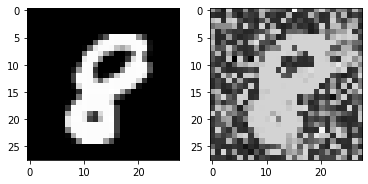

25  :  0.47131782172740594 25
50  :  0.4896294967025395 25
75  :  0.48044879567113324 25
100  :  0.4877298647687626 25
125  :  0.4879623790215258 25
150  :  0.4884433901969099 25
175  :  0.48652170634499364 25
200  :  0.4871760734620123 25
225  :  0.4872395711642882 25
250  :  0.4863475971920897 25
275  :  0.48646497295088 25
300  :  0.48760428574694603 25
325  :  0.4882456246994357 25
350  :  0.48868175940368097 25
375  :  0.48914651876234344 25
400  :  0.4893774435728671 25
425  :  0.4896753749092162 25
450  :  0.4897831121667264 25
475  :  0.4898945710777944 25
500  :  0.48998854164295247 25
525  :  0.49050565925810197 25
550  :  0.49074111975242374 25
575  :  0.49074111975242374 25
600  :  0.49074111975242374 25
625  :  0.49074111975242374 25
650  :  0.4907427526361708 25
675  :  0.49074222829473285 25
700  :  0.49091294117075984 25
725  :  0.4909658618032572 25
750  :  0.491057625874523 25
775  :  0.4910457727308646 25
800  :  0.49120008639670526 25
825  :  0.49134175666063606 25


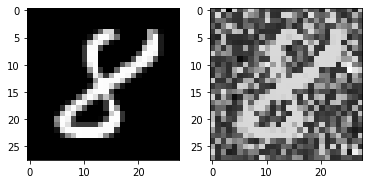

25  :  0.45196508574156985 25
50  :  0.48736312077283755 25
75  :  0.46676379022972 25
100  :  0.4870907253069618 25
125  :  0.4849729765011692 25
150  :  0.4872981787063332 25
175  :  0.48589838985828754 25
200  :  0.4855012661463788 25
225  :  0.4862903762672147 25
250  :  0.48584278525155805 25
275  :  0.4871650930443404 25
300  :  0.48700257478247166 25
325  :  0.4875910023738166 25
350  :  0.4882991631488929 25
375  :  0.48845455796165926 25
400  :  0.48892117145369635 25
425  :  0.48872087282791016 25
450  :  0.4893106631875754 25
475  :  0.4896687511249208 25
500  :  0.4900309268851252 25
525  :  0.49023186640244154 25
550  :  0.490308233843817 25
575  :  0.49065152957789265 25
600  :  0.49065152957789265 25
625  :  0.49065152957789265 25
650  :  0.49065152957789265 25
675  :  0.4906572228536122 25
700  :  0.4908761646233217 25
725  :  0.4909008160539561 25
750  :  0.4909027233281878 25
775  :  0.49107778700589044 25
800  :  0.4910690857474101 25
825  :  0.4910876664496134 25
85

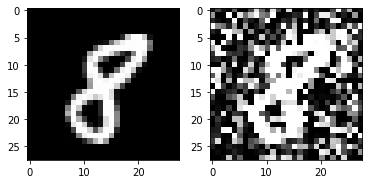

25  :  -0.2545799583847633 25
50  :  -0.2545799583847633 25
75  :  -0.2529831025984902 25
100  :  -0.09348415570216466 25
125  :  -0.028599064045824227 25
150  :  -0.02969502540003884 25
175  :  0.15550828859330704 25
200  :  0.354969504764957 25
225  :  0.3819786716003586 25
250  :  0.371611674242601 25
275  :  0.46091326764362794 25
300  :  0.4587031047960557 25
325  :  0.4841610899803526 25
350  :  0.4845591525534242 25
375  :  0.4867279743207269 25
400  :  0.48611802835064066 25
425  :  0.4871341370875962 25
450  :  0.4870149389309639 25
475  :  0.4869245420944133 25
500  :  0.48790832443111176 25
525  :  0.48776124711421853 25
550  :  0.48795194668335734 25
575  :  0.48812669585355645 25
600  :  0.488212649443929 25
625  :  0.4887836053747714 25
650  :  0.48877160167128775 25
675  :  0.4894260923893802 25
700  :  0.48922335728965993 25
725  :  0.4896757089431056 25
750  :  0.48984436200480336 25
775  :  0.4899637067360816 25
800  :  0.49007372233803315 25
825  :  0.490195763692934

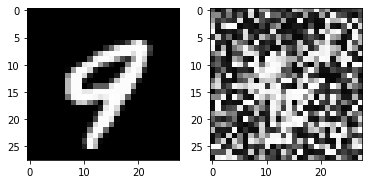

25  :  -0.48723386774465977 25
50  :  -0.20602937493119577 25
75  :  -0.45358300877005486 25
100  :  -0.42522169705718527 25
125  :  -0.40281460249191153 25
150  :  -0.4230770329443402 25
175  :  -0.26963408319952287 25
200  :  -0.055269855151845376 25
225  :  0.1131548390562014 25
250  :  0.3303347080213404 25
275  :  0.4712177034701525 25
300  :  0.4805266760204861 25
325  :  0.48271681605864175 25
350  :  0.4843096237508631 25
375  :  0.48450150336097875 25
400  :  0.4854661677056562 25
425  :  0.48644527413683997 25
450  :  0.48601250743628455 25
475  :  0.4869052544773604 25
500  :  0.4865479265727151 25
525  :  0.4874427818050842 25
550  :  0.4875343080478837 25
575  :  0.4879996804405495 25
600  :  0.4879061348871564 25
625  :  0.48832548333400333 25
650  :  0.4885554733020646 25
675  :  0.48849364650026256 25
700  :  0.48852424113941095 25
725  :  0.48883985674722785 25
750  :  0.48887550250745776 25
775  :  0.48890701075626397 25
800  :  0.4891200075423007 25
825  :  0.4893389

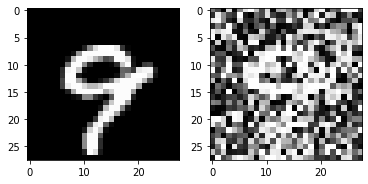

25  :  0.02617457236739912 25
50  :  0.42286775722501174 25
75  :  0.4423762935662999 25
100  :  0.46187910192797355 25
125  :  0.4788281731511436 25
150  :  0.4868131906995143 25
175  :  0.4882106341609847 25
200  :  0.48859762693428055 25
225  :  0.489093342851077 25
250  :  0.4890017833922529 25
275  :  0.48837131149792945 25
300  :  0.4891283595815116 25
325  :  0.49080964833036417 25
350  :  0.4903824039531943 25
375  :  0.49030295798804135 25
400  :  0.49091320895728785 25
425  :  0.4908964905670044 25
450  :  0.49103350673592394 25
475  :  0.49103350673592394 25
500  :  0.49129363200378984 25
525  :  0.49138390759864614 25
550  :  0.491467297103914 25
575  :  0.4917469717495778 25
600  :  0.49177047867716833 25
625  :  0.4917835331754223 25
650  :  0.4918625833592469 25
675  :  0.4918872677086261 25
700  :  0.4918878198430116 25
725  :  0.49196042412014823 25
750  :  0.49201792258294547 25
775  :  0.4920335898736423 25
800  :  0.49205409870406686 25
825  :  0.49205091019218467 2

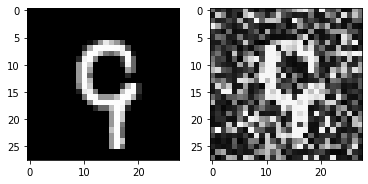

25  :  -0.3210540654974273 25
50  :  0.2841833069979376 25
75  :  -0.06906493455031595 25
100  :  -0.1256602814664735 25
125  :  0.004689831517976995 25
150  :  0.22225504754365372 25
175  :  0.35934628271562785 25
200  :  0.3513492073138389 25
225  :  0.4083757970318514 25
250  :  0.4651843067206368 25
275  :  0.483773336452858 25
300  :  0.4850211404200248 25
325  :  0.4836810710334537 25
350  :  0.48699302904436775 25
375  :  0.4859173562997785 25
400  :  0.4863618892975841 25
425  :  0.4876891597311945 25
450  :  0.48875345826549965 25
475  :  0.4883319818517608 25
500  :  0.4884035280544092 25
525  :  0.48878447566360933 25
550  :  0.4891109139638795 25
575  :  0.48936651125906117 25
600  :  0.4894155045370915 25
625  :  0.4894155045370915 25
650  :  0.4894155045370915 25
675  :  0.48944172276734155 25
700  :  0.4895994597347651 25
725  :  0.48960882155888097 25
750  :  0.4897473231492478 25
775  :  0.4897413485114141 25
800  :  0.4898422497155404 25
825  :  0.489903827548605 25
8

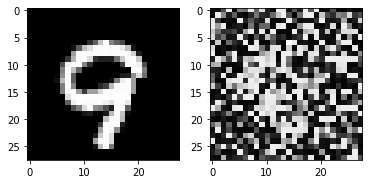

25  :  -0.43771064091890416 25
50  :  -0.32299894726083767 25
75  :  -0.2193136714366606 25
100  :  -0.31599562510903356 25
125  :  -0.04600528271295427 25
150  :  0.11684288600874937 25
175  :  0.1619698411610787 25
200  :  0.03300371146563046 25
225  :  0.29319006066908626 25
250  :  0.27144202891904895 25
275  :  0.2731706731839122 25
300  :  0.482410052725169 25
325  :  0.48542537776390055 25
350  :  0.48650471947437135 25
375  :  0.48780501206216986 25
400  :  0.48755545669453193 25
425  :  0.4883367291755934 25
450  :  0.4899215832080875 25
475  :  0.4901412876096676 25
500  :  0.4906726955175542 25
525  :  0.49062818963747057 25
550  :  0.4907782585513934 25
575  :  0.4907975210363688 25
600  :  0.49093594514350214 25
625  :  0.49103592272031255 25
650  :  0.49138570963033223 25
675  :  0.49123755188608814 25
700  :  0.4915073891867995 25
725  :  0.4915183009908031 25
750  :  0.4915183009908031 25
775  :  0.4915417441045408 25
800  :  0.4915516042066975 25
825  :  0.491666633494

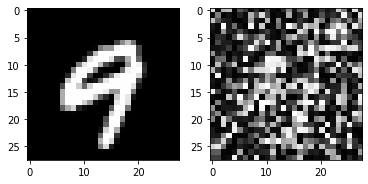

25  :  -0.40925298725834647 25
50  :  -0.15894498164002493 25
75  :  -0.30475658719079435 25
100  :  -0.18472666969519896 25
125  :  0.3804109728216383 25
150  :  0.39632592174242426 25
175  :  0.47832298907845566 25
200  :  0.4830855724773342 25
225  :  0.4827446405522786 25
250  :  0.4829816888096045 25
275  :  0.4840909184886823 25
300  :  0.48394631328848514 25
325  :  0.4843937443408946 25
350  :  0.4864471853216904 25
375  :  0.4867458116511575 25
400  :  0.48768409687689696 25
425  :  0.4874581729347117 25
450  :  0.4880977277178551 25
475  :  0.4880797362916478 25
500  :  0.48857751063345 25
525  :  0.48876808449130343 25
550  :  0.48876808449130343 25
575  :  0.4888217740299767 25
600  :  0.48910162173451344 25
625  :  0.4892125295092293 25
650  :  0.48934019209619395 25
675  :  0.48938918538691656 25
700  :  0.48952873570070154 25
725  :  0.4895432116669811 25
750  :  0.48960318453188606 25
775  :  0.48964251932336283 25
800  :  0.4896620214267077 25
825  :  0.489661994004199

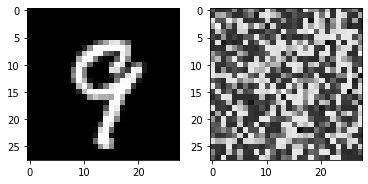

25  :  -0.3134966602784541 25
50  :  0.032037422120153904 25
75  :  -0.167304553293999 25
100  :  0.0074479758085516535 25
125  :  0.11485010929187187 25
150  :  0.37599305230695296 25
175  :  0.4137041274680086 25
200  :  0.4160060105451586 25
225  :  0.4588084647224645 25
250  :  0.44500620528724144 25
275  :  0.4728805525922261 25
300  :  0.44850241746433295 25
325  :  0.45181433970706497 25
350  :  0.4773213674823187 25
375  :  0.4773213674823187 25
400  :  0.4785275013067841 25
425  :  0.48003642220278836 25
450  :  0.48003642220278836 25
475  :  0.48456575550838066 25
500  :  0.4854470014014941 25
525  :  0.48607335502348453 25
550  :  0.48802284821555825 25
575  :  0.4878790369467638 25
600  :  0.48886604484992985 25
625  :  0.49005345577664433 25
650  :  0.49027698495587296 25
675  :  0.4910175430780492 25
700  :  0.49101906728814554 25
725  :  0.4912621624452209 25
750  :  0.4916950247243595 25
775  :  0.49169496514846894 25
800  :  0.4917289058544083 25
825  :  0.491829001335

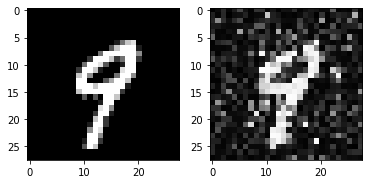

25  :  0.40113604031905326 25
50  :  0.4304634619889768 25
75  :  0.3397995695128883 25
100  :  0.41772536907014657 25
125  :  0.4263783848418935 25
150  :  0.4854631505960625 25
175  :  0.4867488067635598 25
200  :  0.4890909419735218 25
225  :  0.4911196697336315 25
250  :  0.491316731289033 25
275  :  0.4925619626605955 25
300  :  0.49112609943224567 25
325  :  0.4913509938259377 25
350  :  0.49106549918200876 25
375  :  0.49249383368508054 25
400  :  0.4920061285103873 25
425  :  0.49245628994498963 25
450  :  0.4928578456145604 25
475  :  0.4931941338265085 25
500  :  0.49305650445348037 25
525  :  0.4932453228888774 25
550  :  0.49344560573148066 25
575  :  0.4937951031454685 25
600  :  0.49399302298672126 25
625  :  0.49407794285719925 25
650  :  0.49423016110868434 25
675  :  0.49423016110868434 25
700  :  0.4942961160425605 25
725  :  0.4942807511979132 25
750  :  0.4942987938057976 25
775  :  0.4943339639564163 25
800  :  0.4943339639564163 25
825  :  0.4943467276746028 25
85

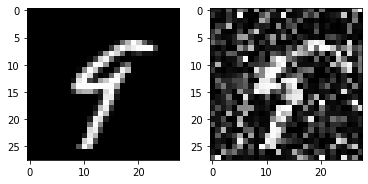

25  :  -0.4861447282540259 25
50  :  -0.0035960133460177174 25
75  :  -0.37278984867508297 25
100  :  -0.27376959990755306 25
125  :  -0.17003525720043608 25
150  :  -0.05118382834305295 25
175  :  0.39758390351940415 25
200  :  0.38374520531301054 25
225  :  0.4780672232442331 25
250  :  0.48448488815004903 25
275  :  0.48608283600698543 25
300  :  0.4854070741505132 25
325  :  0.4856439186143467 25
350  :  0.48701023921836195 25
375  :  0.4876008938502444 25
400  :  0.4884017554716621 25
425  :  0.4880879847232389 25
450  :  0.48814229841176804 25
475  :  0.48923628833446503 25
500  :  0.48881455215690156 25
525  :  0.48881455215690156 25
550  :  0.48957087500464214 25
575  :  0.4897408391894817 25
600  :  0.4897691573831072 25
625  :  0.4898055858354284 25
650  :  0.4903671911022847 25
675  :  0.4903671911022847 25
700  :  0.4903671911022847 25
725  :  0.4903671911022847 25
750  :  0.4904918827949807 25
775  :  0.49061523211163205 25
800  :  0.49080796117154274 25
825  :  0.49091245

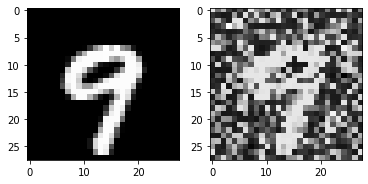

25  :  -0.24880373903865294 25
50  :  0.030745202003432302 25
75  :  0.056014118366492865 25
100  :  0.12534598035085837 25
125  :  0.2947492779594992 25
150  :  0.3434097849956947 25
175  :  0.4634026503914114 25
200  :  0.47389862697230134 25
225  :  0.47558026074341153 25
250  :  0.47913232747861567 25
275  :  0.47913232747861567 25
300  :  0.48307429445273964 25
325  :  0.4848571079551437 25
350  :  0.4898814770020853 25
375  :  0.4896799047278722 25
400  :  0.491034124612298 25
425  :  0.4907458384318868 25
450  :  0.4907458384318868 25
475  :  0.49174525314630707 25
500  :  0.4922285729113489 25
525  :  0.49230856483870017 25
550  :  0.49244844714030317 25
575  :  0.49282241825121914 25
600  :  0.49338462637183594 25
625  :  0.49338303993970895 25
650  :  0.4934836984978181 25
675  :  0.49365381466510366 25
700  :  0.4937972617384483 25
725  :  0.49412566287532395 25
750  :  0.4941192521390623 25
775  :  0.4941192521390623 25
800  :  0.49415620756568623 25
825  :  0.4941799275053

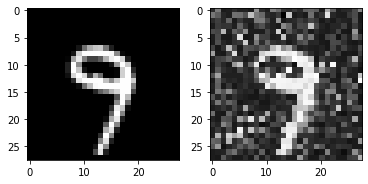

25  :  0.46872734312830383 25
50  :  0.48969826840089187 25
75  :  0.48953605431756414 25
100  :  0.4904153950804593 25
125  :  0.49031535142025207 25
150  :  0.4916963466637447 25
175  :  0.49027129508731304 25
200  :  0.4902560221289438 25
225  :  0.4904652367845961 25
250  :  0.4904109329369706 25
275  :  0.4916917351242174 25
300  :  0.49227034581110096 25
325  :  0.49212360999517757 25
350  :  0.4926317291473318 25
375  :  0.493167093319222 25
400  :  0.493167093319222 25
425  :  0.493167093319222 25
450  :  0.493167093319222 25
475  :  0.49333717834016544 25
500  :  0.49332728480141225 25
525  :  0.4937214136666123 25
550  :  0.4937592250184219 25
575  :  0.4937402155588708 25
600  :  0.4938402341158111 25
625  :  0.4940169636719212 25
650  :  0.4940161843996866 25
675  :  0.49407292497273464 25
700  :  0.4940720391821651 25
725  :  0.49410125756829976 25
750  :  0.49410125756829976 25
775  :  0.49410125756829976 25
800  :  0.49415687929230145 25
825  :  0.49415646339614644 25
Ti

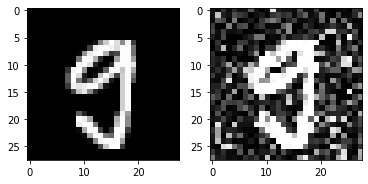

25  :  -0.33707247207142715 25
50  :  0.32674087865564155 25
75  :  -0.08420370513425568 25
100  :  0.26928910311740606 25
125  :  0.35015244735564793 25
150  :  0.3915019715269553 25
175  :  0.4400864185782492 25
200  :  0.47711268224269077 25
225  :  0.4820178312354516 25
250  :  0.4830267818252048 25
275  :  0.48430517979988463 25
300  :  0.48325241782131306 25
325  :  0.4839596792039022 25
350  :  0.48574502631573185 25
375  :  0.4860224733339595 25
400  :  0.48684024723288594 25
425  :  0.4870410898683705 25
450  :  0.48704920929297274 25
475  :  0.48802269013970995 25
500  :  0.48805311680444835 25
525  :  0.48848768680377547 25
550  :  0.4886974181439274 25
575  :  0.4893944522157473 25
600  :  0.4894878572343198 25
625  :  0.48971435498494686 25
650  :  0.4898423092414138 25
675  :  0.4898844608321977 25
700  :  0.49004231824489797 25
725  :  0.49007293614333486 25
750  :  0.49011103400795264 25
775  :  0.49018956389745594 25
800  :  0.4901961586823393 25
825  :  0.490212774388

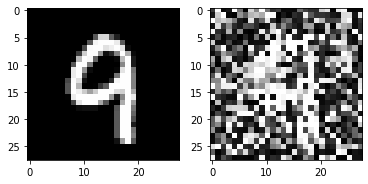

25  :  -0.3936411994055035 25
50  :  0.4259296885695161 25
75  :  -0.17393928718047405 25
100  :  -0.028206133553354284 25
125  :  0.16476276183243277 25
150  :  0.15734858670153945 25
175  :  0.31514979487351613 25
200  :  0.4246455894121288 25
225  :  0.4213752951281109 25
250  :  0.47720594133185956 25
275  :  0.48179864522988797 25
300  :  0.4812354132607711 25
325  :  0.4810823724024034 25
350  :  0.48178656765374456 25
375  :  0.4812980253126779 25
400  :  0.4843987963677442 25
425  :  0.48348105514949385 25
450  :  0.4852784509400685 25
475  :  0.48553733125015036 25
500  :  0.4848852603072214 25
525  :  0.4849544665737517 25
550  :  0.48531345919868063 25
575  :  0.4852224925869526 25
600  :  0.48583780408851873 25
625  :  0.4861433691861743 25
650  :  0.48640252687220953 25
675  :  0.4866113670909114 25
700  :  0.4864275521036237 25
725  :  0.48677393510433425 25
750  :  0.4866970465168415 25
775  :  0.48702220391368845 25
800  :  0.4872268205054271 25
825  :  0.48755812441057

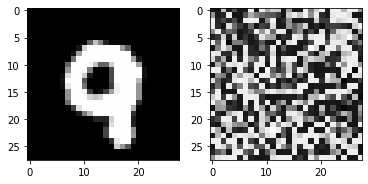

In [22]:
de_npc = DE_NPC(param_dict)
times = []
nfes = []
psnrs = []
predicted_classes = []
for adv_ind in range(adversarial.shape[0]):
  de_npc.change_input(adversarial[adv_ind].reshape((784,1)),adversarial_y[adv_ind],784)
  timed, nfed = de_npc.execute(model)
  times.append(timed)
  nfes.append(nfed)
## increasing coefficient of the first term in fitness function and
## increasing the standard deviation of the noise increases the chance
## to find an adversarial example but it decreases the image quality
## of the adversarial example found
## also this algorithm can discard the best individual in the next generation
## to prevent this we can put it to population[0] after shuffling
  adv = np.clip(de_npc.X_best, 0, 255)
  psnrs.append(PSNR(adversarial[adv_ind],adv))
  preds_adv = model.predict(adv.reshape(1,28*28) / 255.0)
  predicted_classes.extend(np.argmax(preds_adv,axis=1))
  print("Predicted class: ",np.argmax(preds_adv,axis=1))
  fig = plt.figure()
  ax1 = fig.add_subplot(1,2,1)
  ax1.imshow(adversarial[adv_ind].reshape(28,28),cmap="gray")
  ax2 = fig.add_subplot(1,2,2)
  ax2.imshow(de_npc.X_best.reshape(28,28),cmap="gray")
  plt.show()
  adversarial[adv_ind] = de_npc.X_best

In [0]:
file_ = open('adv_de_rbf_mnist', 'wb')
pickle.dump(adversarial, file_)
pickle.dump(times, file_)
pickle.dump(nfes , file_)
pickle.dump(psnrs , file_)
pickle.dump(predicted_classes, file_)
file_.close()

In [28]:
print(np.max(times))
print(np.min(times))
print(np.mean(times))
print(np.std(times))

170.6515350341797
67.86350703239441
96.79268868953463
18.750340963346204


In [29]:
print(np.max(nfes))
print(np.min(nfes))
print(np.mean(nfes))
print(np.std(nfes))

1678
800
999.7142857142857
157.85536162178263


In [30]:
print(np.max(psnrs))
print(np.min(psnrs))
print(np.mean(psnrs))
print(np.std(psnrs))

18.17939300412627
3.7398903169409503
8.386596910304728
3.1567156262543508
